In [1]:
import numpy as np
import os
# import PIL
# import PIL.Image
import cv2
import pandas as pd
import tensorflow as tf
from tensorflow.python.data.ops.dataset_ops import AUTOTUNE
import tensorflow_datasets as tfds
from functools import partial
import pathlib # is it used?
import matplotlib.pyplot as plt
import seaborn as sns

print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)

In [3]:
plt.rcParams['figure.dpi'] = 120
plt.rcParams['savefig.dpi'] = 300

In [4]:
def plotImage(image, cmap=None, title=None):
    plt.figure()
    if cmap != None:
        plt.imshow(image, cmap=cmap)
    else:
        plt.imshow(image)
    if title != None:
        plt.title(title)
    plt.show()

In [5]:
def visualize(original, augmented):
    
    fig = plt.figure()
    plt.subplot(1,2,1)
    plt.title('Original image')
    plt.imshow(original)

    plt.subplot(1,2,2)
    plt.title('Augmented image')
    plt.imshow(augmented)
    plt.show()

In [6]:
def predictionsToText(pred, sep=None):
    txt = ""
#     print(pred)
    for i in pred:
#         print(i)
        txt = f"{txt}{i:.4f} "
    txt = txt.strip()
    if sep != None:
        txt = txt.replace(" ", sep)
    return txt

In [7]:
batch_size = 32
# batch_size = 20
img_height = 740
img_width = 596
slice_size = 60
learning_rate=1e-5
epochs = 700
drop_rate = 0.33

In [8]:
AUTOTUNE = tf.data.AUTOTUNE

In [9]:
def load_labels(data):
    file_name = tf.strings.split(data, sep="/")[-1]
    label1 = tf.strings.split(file_name, sep="_")[0]
    label2 = tf.strings.split(file_name, sep="_")[1]
    label3 = tf.strings.split(file_name, sep="_")[2]
    label4 = tf.strings.split(file_name, sep="_")[3]
    label5 = tf.strings.split(file_name, sep="_")[4]
    label6 = tf.strings.split(file_name, sep="_")[5]
    out1 = 1 if label1 == '1' else 0
    out2 = 1 if label2 == '1' else 0
    out3 = 1 if label3 == '1' else 0
    out4 = 1 if label4 == '1' else 0
    out5 = 1 if label5 == '1' else 0
    out6 = 1 if label6 == '1' else 0
    outa0 = 1 if out1 + out2 + out3 == 0 else 0 #no masks present (Carlefts)
    outa1 = 1 if out1 + out2 + out3 == 1 else 0 #present 1 mask
    outa2 = 1 if out1 + out2 + out3 == 2 else 0 #present 2 masks
    outa3 = 1 if out1 + out2 + out3 == 3 else 0 #present 3 masks
    
    outb0 = 1 if out4 + out5 + out6 == 0 else 0
    outb1 = 1 if out4 + out5 + out6 == 1 else 0
    outb2 = 1 if out4 + out5 + out6 == 2 else 0
    outb3 = 1 if out4 + out5 + out6 == 3 else 0
    
    outa0 = tf.cast(outa0, dtype=tf.float32) #converting values into float
    outa1 = tf.cast(outa1, dtype=tf.float32)
    outa2 = tf.cast(outa2, dtype=tf.float32)
    outa3 = tf.cast(outa3, dtype=tf.float32)
    outb0 = tf.cast(outb0, dtype=tf.float32)
    outb1 = tf.cast(outb1, dtype=tf.float32)
    outb2 = tf.cast(outb2, dtype=tf.float32)
    outb3 = tf.cast(outb3, dtype=tf.float32)
#     out6 = tf.cast(out6, dtype=tf.float32)

    image = tf.io.read_file(data)
    image = tf.image.decode_png(image, channels=1)
    image = tf.cast(image, dtype=tf.float32)
    return (image/255., ([outa0, outa1, outa2, outa3], [outb0, outb1, outb2, outb3]))

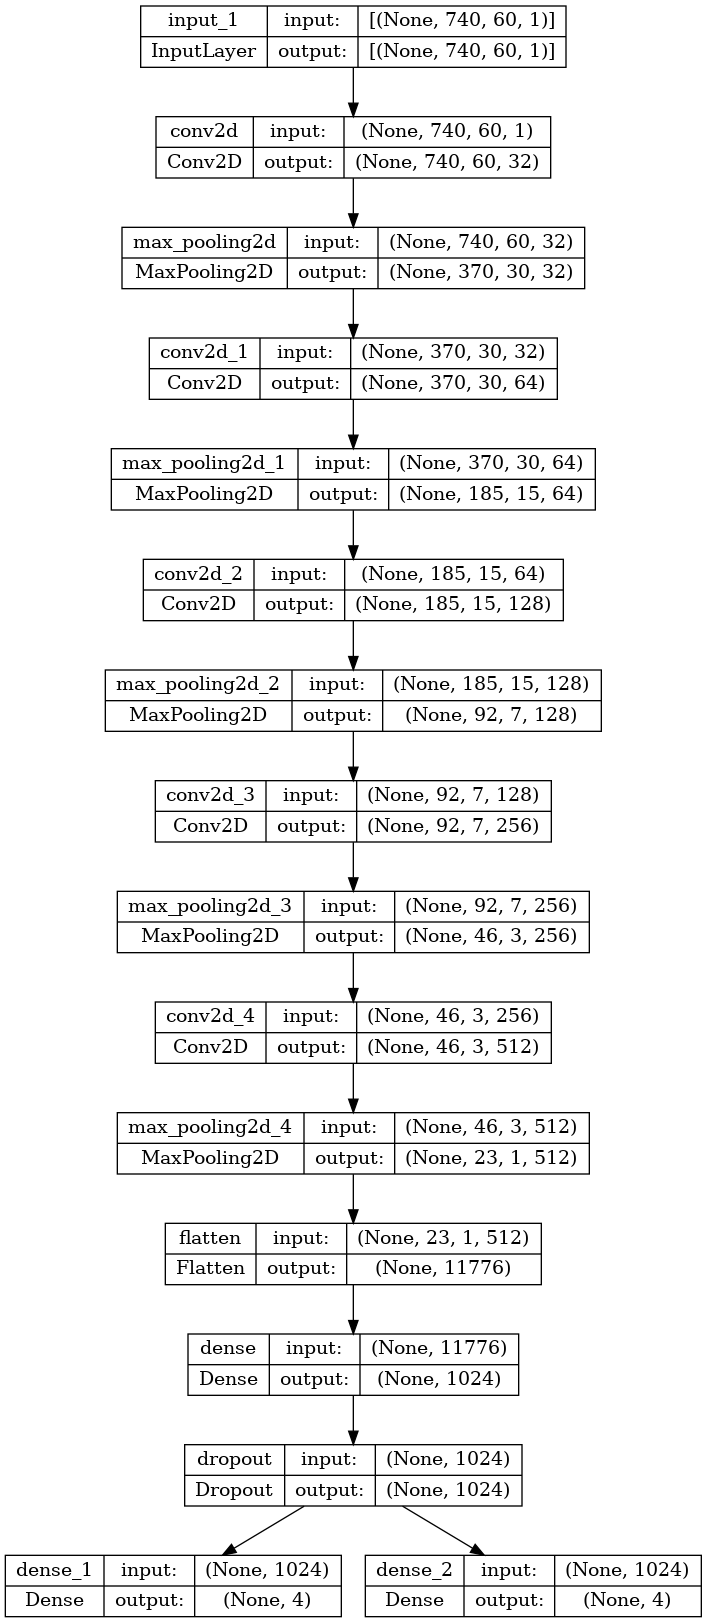

In [10]:
input_layer = tf.keras.layers.Input(shape=(740, slice_size, 1,))
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255.)(input_layer)
# Try valid padding
x = tf.keras.layers.Conv2D(32, kernel_size=(5, 5), strides=(1, 1), padding="same", activation='relu')(input_layer)#(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
# x = tf.keras.layers.Dropout(drop_rate)(x)
x = tf.keras.layers.Conv2D(64, kernel_size=(5, 5), strides=(1, 1), padding="same", activation='relu')(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
# x = tf.keras.layers.Dropout(drop_rate)(x)
x = tf.keras.layers.Conv2D(128, kernel_size=(5, 5), strides=(1, 1), padding="same", activation='relu')(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
# x = tf.keras.layers.Dropout(drop_rate)(x)
x = tf.keras.layers.Conv2D(256, kernel_size=(5, 5), strides=(1, 1), padding="same", activation='relu')(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
# x = tf.keras.layers.Dropout(drop_rate)(x)
x = tf.keras.layers.Conv2D(512, kernel_size=(5, 5), strides=(1, 1), padding="same", activation='relu')(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Flatten()(x)
# x = tf.keras.layers.Dropout(drop_rate)(x)

# x = tf.keras.layers.Dense(512, activation='relu')(x)
# x = tf.keras.layers.Dropout(drop_rate)(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dropout(drop_rate)(x)

#make 6 layers here(x)
x1 = tf.keras.layers.Dense(4, activation='softmax')(x)
x2 = tf.keras.layers.Dense(4, activation='softmax')(x)
# x3 = tf.keras.layers.Dense(1, activation='sigmoid')(x)
# x4 = tf.keras.layers.Dense(1, activation='sigmoid')(x)
# x5 = tf.keras.layers.Dense(1, activation='sigmoid')(x)
# x6 = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(inputs=input_layer, outputs=[x1, x2])
# model = tf.keras.Model(inputs=input_layer, outputs=[x1, x2, x3, x4, x5, x6])

dot_img_file = '/tf/train_py/Architecture_plots/beseline_model_1.png'
tf.keras.utils.plot_model(model, to_file=dot_img_file, show_layer_names=True, show_shapes=True)


In [11]:
tf.random.set_seed(43)
# counter = tf.data.experimental.Counter()
# seeds
#Augmentation
# seed_aug_0 = tf.data.Dataset.from_tensor_slices([10])
# seed_aug_0 = seed_aug_0.repeat(10000000)
# seed_aug_1 = tf.data.Dataset.from_tensor_slices([25])
# seed_aug_1 = seed_aug_1.repeat(10000000)
# seed_aug_2 = tf.data.Dataset.from_tensor_slices([59])
# seed_aug_2 = seed_aug_2.repeat(10000000)


ds_names_o = tf.data.Dataset.list_files(str('./images_split/*.png'), shuffle=False).batch(batch_size)
ds_training_ = tf.data.Dataset.list_files(str('./images_split/*.png'), shuffle=False)
# ds_training = (ds_training
#   .shuffle(180, seed=43)
#   .map(load_labels, num_parallel_calls=AUTOTUNE)
#   .cache()
#   # .repeat()
#   .batch(batch_size)
#   .prefetch(AUTOTUNE)
# )
ds_training_15 = tf.data.Dataset.list_files(str('./images_split_15/*.png'), shuffle=False)
# ds_training_15 = (ds_training_15
#   .shuffle(180, seed=43)
#   .map(load_labels, num_parallel_calls=AUTOTUNE)
#   .cache()
#   # .repeat()
#   .batch(batch_size)
#   .prefetch(AUTOTUNE)
# )
ds_training_30 = tf.data.Dataset.list_files(str('./images_split_30/*.png'), shuffle=False)
# ds_training_30 = (ds_training_30
#   .shuffle(180, seed=43)
#   .map(load_labels, num_parallel_calls=AUTOTUNE)
#   .cache()
#   # .repeat()
#   .batch(batch_size)
#   .prefetch(AUTOTUNE)
# )
ds_training_45 = tf.data.Dataset.list_files(str('./images_split_45/*.png'), shuffle=False)
# ds_training_45 = (ds_training_45
#   .shuffle(180, seed=43)
#   .map(load_labels, num_parallel_calls=AUTOTUNE)
#   .cache()
#   # .repeat()
#   .batch(batch_size)
#   .prefetch(AUTOTUNE)
# )
ds_synth = tf.data.Dataset.list_files(str('./images_synth/*.png'), shuffle=False)
# ds_training_45 = (ds_training_45
#   .shuffle(180, seed=43)
#   .map(load_labels, num_parallel_calls=AUTOTUNE)
#   .cache()
#   # .repeat()
#   .batch(batch_size)
#   .prefetch(AUTOTUNE)
# )

ds_training = ds_training_.concatenate(ds_training_15).concatenate(ds_training_30).concatenate(ds_training_45).concatenate(ds_synth) #names
# ds_training_aug = ds_training
# Augmentation
# ds_training_aug = tf.data.Dataset.zip((ds_training, (seed_aug_0, seed_aug_0)))
# ds_training_aug_1 = tf.data.Dataset.zip((ds_training, (seed_aug_1, seed_aug_1)))
# ds_training_aug_2 = tf.data.Dataset.zip((ds_training, (seed_aug_2, seed_aug_2)))

ds_training = (ds_training
  .shuffle(180, seed=43)
  .map(load_labels, num_parallel_calls=AUTOTUNE)
  .cache()
  # .repeat()
  .batch(batch_size)
  .prefetch(AUTOTUNE)
)
#Augmentation
# ds_training_aug = (ds_training_aug
#   .shuffle(180, seed=43)
#   .map(Augmentation, num_parallel_calls=AUTOTUNE)
#   .cache()
#   # .repeat()
#   .batch(batch_size)
#   .prefetch(AUTOTUNE)
# )
# ds_training_aug_1 = (ds_training_aug_1
#   .shuffle(180, seed=43)
#   .map(Augmentation, num_parallel_calls=AUTOTUNE)
#   .cache()
#   # .repeat()
#   .batch(batch_size)
#   .prefetch(AUTOTUNE)
# )
# ds_training_aug_2 = (ds_training_aug_2
#   .shuffle(180, seed=43)
#   .map(Augmentation, num_parallel_calls=AUTOTUNE)
#   .cache()
#   # .repeat()
#   .batch(batch_size)
#   .prefetch(AUTOTUNE)
# )
# ds_synth = (ds_synth
#   .shuffle(180, seed=43)
#   .map(load_labels, num_parallel_calls=AUTOTUNE)
#   .cache()
#   # .repeat()
#   .batch(batch_size)
#   .prefetch(AUTOTUNE)
# )

# ds_training = ds_training.concatenate(ds_training_aug).concatenate(ds_training_aug_1).concatenate(ds_training_aug_2)
#.concatenate(ds_synth)

ds_val = tf.data.Dataset.list_files(str('./images_split_val/*.png')) #names
# ds_val_aug = ds_val
# Augmentation
# ds_val_aug = tf.data.Dataset.zip((ds_val, (seed_aug_0, seed_aug_0)))
# ds_val_aug_1 = tf.data.Dataset.zip((ds_val, (seed_aug_1, seed_aug_1)))
# ds_val_aug_2 = tf.data.Dataset.zip((ds_val, (seed_aug_2, seed_aug_2)))

ds_val = (ds_val
#   .shuffle(180, seed=3343)
  .map(load_labels, num_parallel_calls=AUTOTUNE)
  .cache()
  # .repeat()
  .batch(batch_size)
  .prefetch(AUTOTUNE)
)
# ds_val_aug = (ds_val_aug
# #   .shuffle(180, seed=3343)
#   .map(Augmentation, num_parallel_calls=AUTOTUNE)
#   .cache()
#   # .repeat()
#   .batch(batch_size)
#   .prefetch(AUTOTUNE)
# )
# ds_val_aug_1 = (ds_val_aug_1
# #   .shuffle(180, seed=3343)
#   .map(Augmentation, num_parallel_calls=AUTOTUNE)
#   .cache()
#   # .repeat()
#   .batch(batch_size)
#   .prefetch(AUTOTUNE)
# )
# ds_val_aug_2 = (ds_val_aug_2
# #   .shuffle(180, seed=3343)
#   .map(Augmentation, num_parallel_calls=AUTOTUNE)
#   .cache()
#   # .repeat()
#   .batch(batch_size)
#   .prefetch(AUTOTUNE)
# )
# ds_val = ds_val.concatenate(ds_val_aug).concatenate(ds_val_aug_1).concatenate(ds_val_aug_2)

ds_test = tf.data.Dataset.list_files(str('./images_split_test/*.png'), shuffle=False)
ds_test = (ds_test
  .shuffle(180, seed=43)
  .map(load_labels, num_parallel_calls=AUTOTUNE)
  .cache()
  # .repeat()
  .batch(batch_size)
  .prefetch(AUTOTUNE)
)

ds_test_names_o = tf.data.Dataset.list_files(str('./images_split_test/*.png'), shuffle=False).batch(100)
# .batch(batch_size)
ds_test_o = tf.data.Dataset.list_files(str('./images_split_test/*.png'), shuffle=False)
ds_test_o = (ds_test_o
#   .shuffle(180, seed=43)
  .map(load_labels, num_parallel_calls=AUTOTUNE)
#   .cache()
#   .repeat()
#   .batch(batch_size)
  .batch(100)
#   .prefetch(AUTOTUNE)
)


In [12]:
# Check label values
it1 = iter(ds_test)
a = [1., 0., 0., 0.]
z = np.round(a,0)

for i in np.arange(13):
    img, labels = next(it1)
    y1, y2 = labels
    b = y1.numpy().shape[0]
#     predictions_test = model.predict(img)
#     PlotDataset(y1,y2)
    print(y1.shape)
    for elem in y1:
        if not (np.array_equal(elem, z)):
            print(((elem).numpy()))
#     for i in np.arange(b):
#         p1, p2 = predictions_test
#         current_name = batch_names[i].numpy().decode("UTF-8")
#         current_img = cv2.imread(current_name, cv2.IMREAD_COLOR)
#         current_img = cv2.cvtColor(current_img, cv2.COLOR_BGR2RGB)
#         plotImage(current_img, title=os.path.basename(current_name))

(32, 4)
(32, 4)
(32, 4)
(32, 4)
(32, 4)
(32, 4)
(32, 4)
(32, 4)
(32, 4)
(32, 4)
(32, 4)
(32, 4)
(32, 4)


In [13]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),#'adam',
  loss=[tf.losses.CategoricalCrossentropy(label_smoothing=0.1),tf.losses.CategoricalCrossentropy(label_smoothing=0.1)],
#   loss=[tf.losses.BinaryCrossentropy(),tf.losses.BinaryCrossentropy(),tf.losses.BinaryCrossentropy(),tf.losses.BinaryCrossentropy(),tf.losses.BinaryCrossentropy(),tf.losses.BinaryCrossentropy()],
  # loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=["accuracy"])
  # metrics=[tf.keras.losses.mean_absolute_error, "accuracy"])

In [14]:
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 740, 60, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d (Conv2D)                (None, 740, 60, 32)  832         ['input_1[0][0]']                
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 370, 30, 32)  0           ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 370, 30, 64)  51264       ['max_pooling2d[0][0]']      

In [15]:
history = model.fit(
  ds_training,
  validation_data=ds_val,
  epochs=500
)

Epoch 1/500
213/213 [==============================] - 26s 92ms/step - loss: 2.3905 - dense_1_loss: 1.1307 - dense_2_loss: 1.2598 - dense_1_accuracy: 0.6111 - dense_2_accuracy: 0.4990 - val_loss: 2.7635 - val_dense_1_loss: 1.5083 - val_dense_2_loss: 1.2553 - val_dense_1_accuracy: 0.1418 - val_dense_2_accuracy: 0.5739
Epoch 2/500
213/213 [==============================] - 17s 80ms/step - loss: 2.4139 - dense_1_loss: 1.1944 - dense_2_loss: 1.2195 - dense_1_accuracy: 0.5351 - dense_2_accuracy: 0.5614 - val_loss: 2.7442 - val_dense_1_loss: 1.5556 - val_dense_2_loss: 1.1886 - val_dense_1_accuracy: 0.1418 - val_dense_2_accuracy: 0.5739
Epoch 3/500
213/213 [==============================] - 17s 80ms/step - loss: 2.4051 - dense_1_loss: 1.1984 - dense_2_loss: 1.2067 - dense_1_accuracy: 0.5285 - dense_2_accuracy: 0.5614 - val_loss: 2.5899 - val_dense_1_loss: 1.3602 - val_dense_2_loss: 1.2297 - val_dense_1_accuracy: 0.1418 - val_dense_2_accuracy: 0.5739
Epoch 4/500
213/213 [======================

Epoch 27/500
213/213 [==============================] - 17s 81ms/step - loss: 2.3586 - dense_1_loss: 1.1386 - dense_2_loss: 1.2200 - dense_1_accuracy: 0.5927 - dense_2_accuracy: 0.5614 - val_loss: 2.5342 - val_dense_1_loss: 1.2597 - val_dense_2_loss: 1.2745 - val_dense_1_accuracy: 0.5918 - val_dense_2_accuracy: 0.5739
Epoch 28/500
213/213 [==============================] - 17s 81ms/step - loss: 2.3690 - dense_1_loss: 1.1492 - dense_2_loss: 1.2198 - dense_1_accuracy: 0.5927 - dense_2_accuracy: 0.5614 - val_loss: 2.4708 - val_dense_1_loss: 1.2228 - val_dense_2_loss: 1.2480 - val_dense_1_accuracy: 0.5918 - val_dense_2_accuracy: 0.5739
Epoch 29/500
213/213 [==============================] - 17s 81ms/step - loss: 2.3553 - dense_1_loss: 1.1358 - dense_2_loss: 1.2195 - dense_1_accuracy: 0.5927 - dense_2_accuracy: 0.5614 - val_loss: 2.5172 - val_dense_1_loss: 1.2519 - val_dense_2_loss: 1.2652 - val_dense_1_accuracy: 0.5918 - val_dense_2_accuracy: 0.5739
Epoch 30/500
213/213 [==================

Epoch 53/500
213/213 [==============================] - 17s 81ms/step - loss: 2.3162 - dense_1_loss: 1.1171 - dense_2_loss: 1.1991 - dense_1_accuracy: 0.5927 - dense_2_accuracy: 0.5614 - val_loss: 2.4149 - val_dense_1_loss: 1.1939 - val_dense_2_loss: 1.2210 - val_dense_1_accuracy: 0.5918 - val_dense_2_accuracy: 0.5739
Epoch 54/500
213/213 [==============================] - 17s 80ms/step - loss: 2.2960 - dense_1_loss: 1.1084 - dense_2_loss: 1.1876 - dense_1_accuracy: 0.5927 - dense_2_accuracy: 0.5614 - val_loss: 2.4124 - val_dense_1_loss: 1.1938 - val_dense_2_loss: 1.2186 - val_dense_1_accuracy: 0.5918 - val_dense_2_accuracy: 0.5739
Epoch 55/500
213/213 [==============================] - 17s 81ms/step - loss: 2.2887 - dense_1_loss: 1.1035 - dense_2_loss: 1.1852 - dense_1_accuracy: 0.5927 - dense_2_accuracy: 0.5614 - val_loss: 2.4242 - val_dense_1_loss: 1.2120 - val_dense_2_loss: 1.2122 - val_dense_1_accuracy: 0.5918 - val_dense_2_accuracy: 0.5739
Epoch 56/500
213/213 [==================

Epoch 79/500
213/213 [==============================] - 17s 81ms/step - loss: 2.1223 - dense_1_loss: 1.0193 - dense_2_loss: 1.1030 - dense_1_accuracy: 0.5944 - dense_2_accuracy: 0.5610 - val_loss: 2.3167 - val_dense_1_loss: 1.1718 - val_dense_2_loss: 1.1449 - val_dense_1_accuracy: 0.5918 - val_dense_2_accuracy: 0.5739
Epoch 80/500
213/213 [==============================] - 17s 81ms/step - loss: 2.0769 - dense_1_loss: 0.9903 - dense_2_loss: 1.0867 - dense_1_accuracy: 0.5982 - dense_2_accuracy: 0.5601 - val_loss: 2.3516 - val_dense_1_loss: 1.2018 - val_dense_2_loss: 1.1498 - val_dense_1_accuracy: 0.5748 - val_dense_2_accuracy: 0.5739
Epoch 81/500
213/213 [==============================] - 17s 80ms/step - loss: 2.0294 - dense_1_loss: 0.9569 - dense_2_loss: 1.0724 - dense_1_accuracy: 0.6502 - dense_2_accuracy: 0.5581 - val_loss: 2.5179 - val_dense_1_loss: 1.3302 - val_dense_2_loss: 1.1877 - val_dense_1_accuracy: 0.3420 - val_dense_2_accuracy: 0.5739
Epoch 82/500
213/213 [==================

Epoch 105/500
213/213 [==============================] - 17s 81ms/step - loss: 1.9367 - dense_1_loss: 0.9260 - dense_2_loss: 1.0106 - dense_1_accuracy: 0.6730 - dense_2_accuracy: 0.5544 - val_loss: 2.9241 - val_dense_1_loss: 1.5077 - val_dense_2_loss: 1.4165 - val_dense_1_accuracy: 0.3124 - val_dense_2_accuracy: 0.5739
Epoch 106/500
213/213 [==============================] - 17s 81ms/step - loss: 2.0264 - dense_1_loss: 0.9493 - dense_2_loss: 1.0770 - dense_1_accuracy: 0.6553 - dense_2_accuracy: 0.5389 - val_loss: 4.9987 - val_dense_1_loss: 3.2258 - val_dense_2_loss: 1.7729 - val_dense_1_accuracy: 0.1418 - val_dense_2_accuracy: 0.5739
Epoch 107/500
213/213 [==============================] - 17s 81ms/step - loss: 1.9428 - dense_1_loss: 0.9442 - dense_2_loss: 0.9987 - dense_1_accuracy: 0.6529 - dense_2_accuracy: 0.5747 - val_loss: 3.3580 - val_dense_1_loss: 1.7305 - val_dense_2_loss: 1.6275 - val_dense_1_accuracy: 0.3044 - val_dense_2_accuracy: 0.5739
Epoch 108/500
213/213 [==============

213/213 [==============================] - 17s 81ms/step - loss: 2.0041 - dense_1_loss: 0.9085 - dense_2_loss: 1.0956 - dense_1_accuracy: 0.6886 - dense_2_accuracy: 0.4782 - val_loss: 2.4356 - val_dense_1_loss: 1.2778 - val_dense_2_loss: 1.1577 - val_dense_1_accuracy: 0.3709 - val_dense_2_accuracy: 0.5620
Epoch 131/500
213/213 [==============================] - 17s 81ms/step - loss: 2.0246 - dense_1_loss: 0.9460 - dense_2_loss: 1.0786 - dense_1_accuracy: 0.6742 - dense_2_accuracy: 0.5118 - val_loss: 2.2684 - val_dense_1_loss: 1.1353 - val_dense_2_loss: 1.1331 - val_dense_1_accuracy: 0.4602 - val_dense_2_accuracy: 0.5603
Epoch 132/500
213/213 [==============================] - 17s 81ms/step - loss: 1.9688 - dense_1_loss: 0.9464 - dense_2_loss: 1.0224 - dense_1_accuracy: 0.6461 - dense_2_accuracy: 0.5717 - val_loss: 2.1320 - val_dense_1_loss: 1.0739 - val_dense_2_loss: 1.0582 - val_dense_1_accuracy: 0.5122 - val_dense_2_accuracy: 0.5731
Epoch 133/500
213/213 [============================

Epoch 156/500
213/213 [==============================] - 17s 81ms/step - loss: 1.7275 - dense_1_loss: 0.8164 - dense_2_loss: 0.9111 - dense_1_accuracy: 0.7352 - dense_2_accuracy: 0.6551 - val_loss: 3.1618 - val_dense_1_loss: 1.7594 - val_dense_2_loss: 1.4023 - val_dense_1_accuracy: 0.1526 - val_dense_2_accuracy: 0.5725
Epoch 157/500
213/213 [==============================] - 17s 81ms/step - loss: 1.7094 - dense_1_loss: 0.7984 - dense_2_loss: 0.9110 - dense_1_accuracy: 0.7547 - dense_2_accuracy: 0.6530 - val_loss: 4.1141 - val_dense_1_loss: 2.5132 - val_dense_2_loss: 1.6009 - val_dense_1_accuracy: 0.1509 - val_dense_2_accuracy: 0.5736
Epoch 158/500
213/213 [==============================] - 17s 81ms/step - loss: 1.6850 - dense_1_loss: 0.7907 - dense_2_loss: 0.8943 - dense_1_accuracy: 0.7654 - dense_2_accuracy: 0.6639 - val_loss: 3.5690 - val_dense_1_loss: 1.7963 - val_dense_2_loss: 1.7727 - val_dense_1_accuracy: 0.4636 - val_dense_2_accuracy: 0.5728
Epoch 159/500
213/213 [==============

213/213 [==============================] - 17s 81ms/step - loss: 1.5172 - dense_1_loss: 0.6807 - dense_2_loss: 0.8365 - dense_1_accuracy: 0.8314 - dense_2_accuracy: 0.7206 - val_loss: 3.3026 - val_dense_1_loss: 1.6665 - val_dense_2_loss: 1.6362 - val_dense_1_accuracy: 0.4991 - val_dense_2_accuracy: 0.5836
Epoch 182/500
213/213 [==============================] - 17s 81ms/step - loss: 1.5258 - dense_1_loss: 0.6739 - dense_2_loss: 0.8519 - dense_1_accuracy: 0.8270 - dense_2_accuracy: 0.7127 - val_loss: 3.7114 - val_dense_1_loss: 2.3137 - val_dense_2_loss: 1.3977 - val_dense_1_accuracy: 0.1751 - val_dense_2_accuracy: 0.5745
Epoch 183/500
213/213 [==============================] - 17s 81ms/step - loss: 1.5353 - dense_1_loss: 0.6728 - dense_2_loss: 0.8625 - dense_1_accuracy: 0.8360 - dense_2_accuracy: 0.6989 - val_loss: 3.2533 - val_dense_1_loss: 1.8621 - val_dense_2_loss: 1.3912 - val_dense_1_accuracy: 0.4540 - val_dense_2_accuracy: 0.5836
Epoch 184/500
213/213 [============================

Epoch 207/500
213/213 [==============================] - 17s 81ms/step - loss: 1.3506 - dense_1_loss: 0.5830 - dense_2_loss: 0.7676 - dense_1_accuracy: 0.8893 - dense_2_accuracy: 0.7745 - val_loss: 3.2495 - val_dense_1_loss: 1.8039 - val_dense_2_loss: 1.4457 - val_dense_1_accuracy: 0.3914 - val_dense_2_accuracy: 0.6148
Epoch 208/500
213/213 [==============================] - 17s 81ms/step - loss: 1.2936 - dense_1_loss: 0.5713 - dense_2_loss: 0.7224 - dense_1_accuracy: 0.8993 - dense_2_accuracy: 0.8113 - val_loss: 2.7449 - val_dense_1_loss: 1.4972 - val_dense_2_loss: 1.2477 - val_dense_1_accuracy: 0.5472 - val_dense_2_accuracy: 0.6163
Epoch 209/500
213/213 [==============================] - 17s 81ms/step - loss: 1.3347 - dense_1_loss: 0.5791 - dense_2_loss: 0.7556 - dense_1_accuracy: 0.8908 - dense_2_accuracy: 0.7790 - val_loss: 3.0600 - val_dense_1_loss: 1.6767 - val_dense_2_loss: 1.3833 - val_dense_1_accuracy: 0.4395 - val_dense_2_accuracy: 0.6143
Epoch 210/500
213/213 [==============

213/213 [==============================] - 17s 81ms/step - loss: 1.2456 - dense_1_loss: 0.5487 - dense_2_loss: 0.6969 - dense_1_accuracy: 0.9102 - dense_2_accuracy: 0.8235 - val_loss: 2.3857 - val_dense_1_loss: 1.3808 - val_dense_2_loss: 1.0049 - val_dense_1_accuracy: 0.5037 - val_dense_2_accuracy: 0.6572
Epoch 233/500
213/213 [==============================] - 17s 81ms/step - loss: 1.2626 - dense_1_loss: 0.5571 - dense_2_loss: 0.7055 - dense_1_accuracy: 0.9111 - dense_2_accuracy: 0.8141 - val_loss: 2.2163 - val_dense_1_loss: 1.2168 - val_dense_2_loss: 0.9994 - val_dense_1_accuracy: 0.5932 - val_dense_2_accuracy: 0.6595
Epoch 234/500
213/213 [==============================] - 17s 81ms/step - loss: 1.2011 - dense_1_loss: 0.5273 - dense_2_loss: 0.6738 - dense_1_accuracy: 0.9217 - dense_2_accuracy: 0.8317 - val_loss: 2.3192 - val_dense_1_loss: 1.3126 - val_dense_2_loss: 1.0066 - val_dense_1_accuracy: 0.5580 - val_dense_2_accuracy: 0.6489
Epoch 235/500
213/213 [============================

Epoch 258/500
213/213 [==============================] - 17s 81ms/step - loss: 1.1916 - dense_1_loss: 0.5508 - dense_2_loss: 0.6409 - dense_1_accuracy: 0.9052 - dense_2_accuracy: 0.8489 - val_loss: 1.5907 - val_dense_1_loss: 0.8460 - val_dense_2_loss: 0.7446 - val_dense_1_accuracy: 0.7590 - val_dense_2_accuracy: 0.7953
Epoch 259/500
213/213 [==============================] - 17s 81ms/step - loss: 1.1856 - dense_1_loss: 0.5751 - dense_2_loss: 0.6105 - dense_1_accuracy: 0.8787 - dense_2_accuracy: 0.8785 - val_loss: 1.6443 - val_dense_1_loss: 0.8436 - val_dense_2_loss: 0.8008 - val_dense_1_accuracy: 0.7294 - val_dense_2_accuracy: 0.7939
Epoch 260/500
213/213 [==============================] - 17s 81ms/step - loss: 1.1766 - dense_1_loss: 0.5656 - dense_2_loss: 0.6110 - dense_1_accuracy: 0.8855 - dense_2_accuracy: 0.8664 - val_loss: 1.7217 - val_dense_1_loss: 0.8885 - val_dense_2_loss: 0.8332 - val_dense_1_accuracy: 0.6791 - val_dense_2_accuracy: 0.7374
Epoch 261/500
213/213 [==============

213/213 [==============================] - 17s 81ms/step - loss: 1.0587 - dense_1_loss: 0.4852 - dense_2_loss: 0.5734 - dense_1_accuracy: 0.9406 - dense_2_accuracy: 0.8905 - val_loss: 1.5226 - val_dense_1_loss: 0.8369 - val_dense_2_loss: 0.6857 - val_dense_1_accuracy: 0.8007 - val_dense_2_accuracy: 0.8232
Epoch 284/500
213/213 [==============================] - 17s 81ms/step - loss: 1.0835 - dense_1_loss: 0.5162 - dense_2_loss: 0.5673 - dense_1_accuracy: 0.9268 - dense_2_accuracy: 0.8990 - val_loss: 1.4136 - val_dense_1_loss: 0.7487 - val_dense_2_loss: 0.6648 - val_dense_1_accuracy: 0.8272 - val_dense_2_accuracy: 0.8368
Epoch 285/500
213/213 [==============================] - 17s 81ms/step - loss: 1.0892 - dense_1_loss: 0.5303 - dense_2_loss: 0.5589 - dense_1_accuracy: 0.9067 - dense_2_accuracy: 0.9030 - val_loss: 1.4765 - val_dense_1_loss: 0.7544 - val_dense_2_loss: 0.7220 - val_dense_1_accuracy: 0.7922 - val_dense_2_accuracy: 0.8087
Epoch 286/500
213/213 [============================

Epoch 309/500
213/213 [==============================] - 17s 81ms/step - loss: 0.8962 - dense_1_loss: 0.4266 - dense_2_loss: 0.4696 - dense_1_accuracy: 0.9774 - dense_2_accuracy: 0.9539 - val_loss: 1.3524 - val_dense_1_loss: 0.7176 - val_dense_2_loss: 0.6348 - val_dense_1_accuracy: 0.8326 - val_dense_2_accuracy: 0.8584
Epoch 310/500
213/213 [==============================] - 17s 80ms/step - loss: 0.8945 - dense_1_loss: 0.4265 - dense_2_loss: 0.4680 - dense_1_accuracy: 0.9769 - dense_2_accuracy: 0.9561 - val_loss: 1.3576 - val_dense_1_loss: 0.7151 - val_dense_2_loss: 0.6425 - val_dense_1_accuracy: 0.8320 - val_dense_2_accuracy: 0.8530
Epoch 311/500
213/213 [==============================] - 17s 81ms/step - loss: 0.8953 - dense_1_loss: 0.4271 - dense_2_loss: 0.4682 - dense_1_accuracy: 0.9768 - dense_2_accuracy: 0.9572 - val_loss: 1.3660 - val_dense_1_loss: 0.7151 - val_dense_2_loss: 0.6509 - val_dense_1_accuracy: 0.8343 - val_dense_2_accuracy: 0.8468
Epoch 312/500
213/213 [==============

213/213 [==============================] - 17s 81ms/step - loss: 0.8646 - dense_1_loss: 0.4197 - dense_2_loss: 0.4448 - dense_1_accuracy: 0.9822 - dense_2_accuracy: 0.9693 - val_loss: 1.2419 - val_dense_1_loss: 0.6316 - val_dense_2_loss: 0.6104 - val_dense_1_accuracy: 0.8633 - val_dense_2_accuracy: 0.8732
Epoch 335/500
213/213 [==============================] - 17s 81ms/step - loss: 0.8677 - dense_1_loss: 0.4237 - dense_2_loss: 0.4440 - dense_1_accuracy: 0.9796 - dense_2_accuracy: 0.9703 - val_loss: 1.2143 - val_dense_1_loss: 0.6112 - val_dense_2_loss: 0.6031 - val_dense_1_accuracy: 0.8729 - val_dense_2_accuracy: 0.8729
Epoch 336/500
213/213 [==============================] - 17s 81ms/step - loss: 0.8755 - dense_1_loss: 0.4304 - dense_2_loss: 0.4452 - dense_1_accuracy: 0.9749 - dense_2_accuracy: 0.9694 - val_loss: 1.2212 - val_dense_1_loss: 0.5933 - val_dense_2_loss: 0.6279 - val_dense_1_accuracy: 0.8823 - val_dense_2_accuracy: 0.8613
Epoch 337/500
213/213 [============================

Epoch 360/500
213/213 [==============================] - 17s 82ms/step - loss: 0.7906 - dense_1_loss: 0.3887 - dense_2_loss: 0.4019 - dense_1_accuracy: 0.9960 - dense_2_accuracy: 0.9916 - val_loss: 1.1871 - val_dense_1_loss: 0.5971 - val_dense_2_loss: 0.5900 - val_dense_1_accuracy: 0.8775 - val_dense_2_accuracy: 0.8829
Epoch 361/500
213/213 [==============================] - 17s 82ms/step - loss: 0.7896 - dense_1_loss: 0.3886 - dense_2_loss: 0.4010 - dense_1_accuracy: 0.9954 - dense_2_accuracy: 0.9928 - val_loss: 1.1790 - val_dense_1_loss: 0.5938 - val_dense_2_loss: 0.5852 - val_dense_1_accuracy: 0.8783 - val_dense_2_accuracy: 0.8818
Epoch 362/500
213/213 [==============================] - 17s 81ms/step - loss: 0.7874 - dense_1_loss: 0.3873 - dense_2_loss: 0.4001 - dense_1_accuracy: 0.9963 - dense_2_accuracy: 0.9922 - val_loss: 1.1772 - val_dense_1_loss: 0.5939 - val_dense_2_loss: 0.5833 - val_dense_1_accuracy: 0.8766 - val_dense_2_accuracy: 0.8840
Epoch 363/500
213/213 [==============

213/213 [==============================] - 17s 81ms/step - loss: 0.7662 - dense_1_loss: 0.3784 - dense_2_loss: 0.3878 - dense_1_accuracy: 0.9982 - dense_2_accuracy: 0.9969 - val_loss: 1.1944 - val_dense_1_loss: 0.5927 - val_dense_2_loss: 0.6017 - val_dense_1_accuracy: 0.8798 - val_dense_2_accuracy: 0.8889
Epoch 386/500
213/213 [==============================] - 17s 81ms/step - loss: 0.7668 - dense_1_loss: 0.3789 - dense_2_loss: 0.3879 - dense_1_accuracy: 0.9988 - dense_2_accuracy: 0.9968 - val_loss: 1.2059 - val_dense_1_loss: 0.5925 - val_dense_2_loss: 0.6134 - val_dense_1_accuracy: 0.8789 - val_dense_2_accuracy: 0.8812
Epoch 387/500
213/213 [==============================] - 17s 81ms/step - loss: 0.7695 - dense_1_loss: 0.3798 - dense_2_loss: 0.3897 - dense_1_accuracy: 0.9984 - dense_2_accuracy: 0.9951 - val_loss: 1.1682 - val_dense_1_loss: 0.5688 - val_dense_2_loss: 0.5994 - val_dense_1_accuracy: 0.8883 - val_dense_2_accuracy: 0.8852
Epoch 388/500
213/213 [============================

Epoch 411/500
213/213 [==============================] - 17s 81ms/step - loss: 0.7441 - dense_1_loss: 0.3700 - dense_2_loss: 0.3741 - dense_1_accuracy: 0.9993 - dense_2_accuracy: 0.9990 - val_loss: 1.1026 - val_dense_1_loss: 0.5349 - val_dense_2_loss: 0.5677 - val_dense_1_accuracy: 0.9036 - val_dense_2_accuracy: 0.9022
Epoch 412/500
213/213 [==============================] - 17s 81ms/step - loss: 0.7428 - dense_1_loss: 0.3689 - dense_2_loss: 0.3739 - dense_1_accuracy: 0.9994 - dense_2_accuracy: 0.9990 - val_loss: 1.0942 - val_dense_1_loss: 0.5308 - val_dense_2_loss: 0.5633 - val_dense_1_accuracy: 0.9048 - val_dense_2_accuracy: 0.9056
Epoch 413/500
213/213 [==============================] - 17s 81ms/step - loss: 0.7420 - dense_1_loss: 0.3684 - dense_2_loss: 0.3735 - dense_1_accuracy: 0.9994 - dense_2_accuracy: 0.9985 - val_loss: 1.0862 - val_dense_1_loss: 0.5279 - val_dense_2_loss: 0.5582 - val_dense_1_accuracy: 0.9048 - val_dense_2_accuracy: 0.9059
Epoch 414/500
213/213 [==============

213/213 [==============================] - 17s 81ms/step - loss: 0.7277 - dense_1_loss: 0.3625 - dense_2_loss: 0.3652 - dense_1_accuracy: 0.9996 - dense_2_accuracy: 0.9997 - val_loss: 1.0758 - val_dense_1_loss: 0.5291 - val_dense_2_loss: 0.5467 - val_dense_1_accuracy: 0.9051 - val_dense_2_accuracy: 0.9119
Epoch 437/500
213/213 [==============================] - 17s 81ms/step - loss: 0.7273 - dense_1_loss: 0.3626 - dense_2_loss: 0.3647 - dense_1_accuracy: 0.9996 - dense_2_accuracy: 0.9997 - val_loss: 1.0789 - val_dense_1_loss: 0.5312 - val_dense_2_loss: 0.5477 - val_dense_1_accuracy: 0.9036 - val_dense_2_accuracy: 0.9105
Epoch 438/500
213/213 [==============================] - 17s 82ms/step - loss: 0.7266 - dense_1_loss: 0.3621 - dense_2_loss: 0.3645 - dense_1_accuracy: 0.9997 - dense_2_accuracy: 0.9999 - val_loss: 1.0865 - val_dense_1_loss: 0.5376 - val_dense_2_loss: 0.5489 - val_dense_1_accuracy: 0.9008 - val_dense_2_accuracy: 0.9119
Epoch 439/500
213/213 [============================

Epoch 462/500
213/213 [==============================] - 17s 82ms/step - loss: 0.7208 - dense_1_loss: 0.3597 - dense_2_loss: 0.3611 - dense_1_accuracy: 0.9999 - dense_2_accuracy: 1.0000 - val_loss: 1.0818 - val_dense_1_loss: 0.5339 - val_dense_2_loss: 0.5479 - val_dense_1_accuracy: 0.8999 - val_dense_2_accuracy: 0.9144
Epoch 463/500
213/213 [==============================] - 17s 82ms/step - loss: 0.7209 - dense_1_loss: 0.3597 - dense_2_loss: 0.3611 - dense_1_accuracy: 0.9999 - dense_2_accuracy: 0.9999 - val_loss: 1.0780 - val_dense_1_loss: 0.5312 - val_dense_2_loss: 0.5469 - val_dense_1_accuracy: 0.9053 - val_dense_2_accuracy: 0.9125
Epoch 464/500
213/213 [==============================] - 17s 81ms/step - loss: 0.7208 - dense_1_loss: 0.3596 - dense_2_loss: 0.3612 - dense_1_accuracy: 0.9999 - dense_2_accuracy: 1.0000 - val_loss: 1.0788 - val_dense_1_loss: 0.5315 - val_dense_2_loss: 0.5473 - val_dense_1_accuracy: 0.9059 - val_dense_2_accuracy: 0.9116
Epoch 465/500
213/213 [==============

213/213 [==============================] - 17s 81ms/step - loss: 0.7193 - dense_1_loss: 0.3591 - dense_2_loss: 0.3602 - dense_1_accuracy: 0.9999 - dense_2_accuracy: 1.0000 - val_loss: 1.0586 - val_dense_1_loss: 0.5119 - val_dense_2_loss: 0.5466 - val_dense_1_accuracy: 0.9147 - val_dense_2_accuracy: 0.9068
Epoch 488/500
213/213 [==============================] - 17s 81ms/step - loss: 0.7183 - dense_1_loss: 0.3587 - dense_2_loss: 0.3596 - dense_1_accuracy: 0.9999 - dense_2_accuracy: 1.0000 - val_loss: 1.0658 - val_dense_1_loss: 0.5181 - val_dense_2_loss: 0.5477 - val_dense_1_accuracy: 0.9102 - val_dense_2_accuracy: 0.9093
Epoch 489/500
213/213 [==============================] - 17s 81ms/step - loss: 0.7180 - dense_1_loss: 0.3585 - dense_2_loss: 0.3595 - dense_1_accuracy: 0.9999 - dense_2_accuracy: 1.0000 - val_loss: 1.0584 - val_dense_1_loss: 0.5136 - val_dense_2_loss: 0.5448 - val_dense_1_accuracy: 0.9127 - val_dense_2_accuracy: 0.9093
Epoch 490/500
213/213 [============================

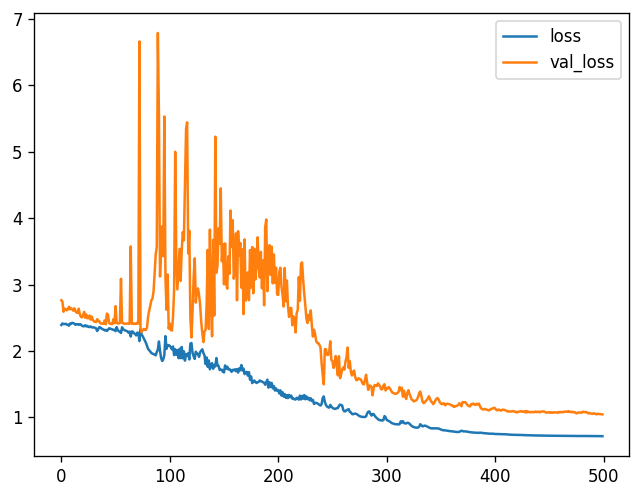

110/110 [==============================] - 3s 28ms/step - loss: 1.0421 - dense_1_loss: 0.5027 - dense_2_loss: 0.5394 - dense_1_accuracy: 0.9240 - dense_2_accuracy: 0.9099
[1.042060136795044, 0.5026675462722778, 0.5393926501274109, 0.923956573009491, 0.9099485278129578]


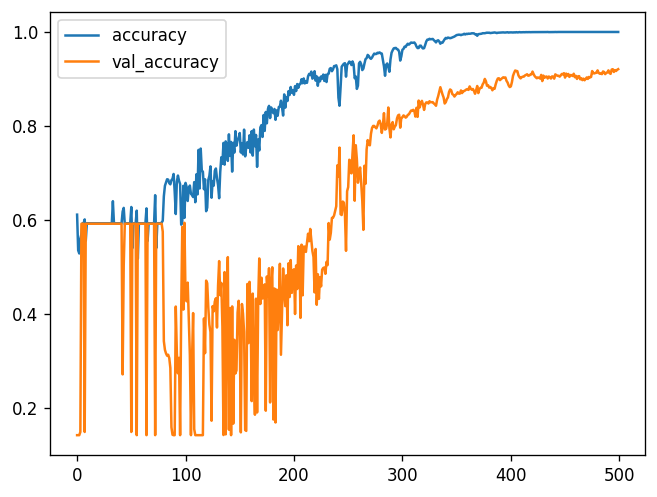

110/110 [==============================] - 3s 28ms/step - loss: 1.0421 - dense_1_loss: 0.5027 - dense_2_loss: 0.5394 - dense_1_accuracy: 0.9240 - dense_2_accuracy: 0.9099
[1.042060136795044, 0.5026675462722778, 0.5393926501274109, 0.923956573009491, 0.9099485278129578]


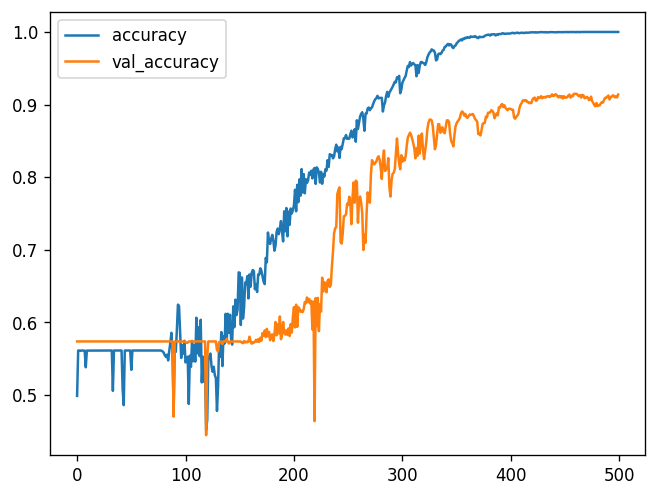

110/110 [==============================] - 3s 28ms/step - loss: 1.0421 - dense_1_loss: 0.5027 - dense_2_loss: 0.5394 - dense_1_accuracy: 0.9240 - dense_2_accuracy: 0.9099
[1.042060136795044, 0.5026675462722778, 0.5393926501274109, 0.923956573009491, 0.9099485278129578]


In [16]:
metrics2 = history.history
plt.plot(history.epoch, metrics2['loss'], metrics2['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()
print(model.evaluate(ds_test))
plt.plot(history.epoch, metrics2['dense_1_accuracy'], metrics2['val_dense_1_accuracy'])
plt.legend(['accuracy', 'val_accuracy'])
plt.show()
print(model.evaluate(ds_test))
plt.plot(history.epoch, metrics2['dense_2_accuracy'], metrics2['val_dense_2_accuracy'])
plt.legend(['accuracy', 'val_accuracy'])
plt.show()
print(model.evaluate(ds_test))

In [17]:
predictions = model.predict(ds_test)

110/110 [==============================] - 3s 22ms/step


In [18]:
p1, p2 = predictions
# p1, p2, p3, p4, p5, p6 = predictions

In [19]:
# predictions converted in human readable format
k = 1
for i in np.arange(p1.shape[0]):
    txt = "["
    txt = f"{txt} {predictionsToText(p1[i])}"
#     for j in p1[i]:
#         txt = f"{txt} {j:.4f}"
    txt = f"{txt} ::"
    txt = f"{txt} {predictionsToText(p2[i])}"
#     for j in p2[i]:
#         txt = f"{txt} {j:.4f}"
    txt = f"{k:04d}: {txt} ]"
    k = k + 1
    print(txt)

0001: [ 0.9084 0.0304 0.0321 0.0291 :: 0.9096 0.0311 0.0294 0.0299 ]
0002: [ 0.9015 0.0219 0.0352 0.0414 :: 0.3662 0.5032 0.0614 0.0692 ]
0003: [ 0.9298 0.0176 0.0277 0.0249 :: 0.9277 0.0208 0.0253 0.0261 ]
0004: [ 0.9062 0.0290 0.0314 0.0334 :: 0.8992 0.0398 0.0296 0.0314 ]
0005: [ 0.9188 0.0261 0.0273 0.0277 :: 0.9221 0.0246 0.0261 0.0272 ]
0006: [ 0.9015 0.0329 0.0300 0.0357 :: 0.8393 0.0763 0.0404 0.0440 ]
0007: [ 0.8691 0.0423 0.0373 0.0514 :: 0.7714 0.1096 0.0741 0.0449 ]
0008: [ 0.9267 0.0257 0.0227 0.0249 :: 0.9285 0.0243 0.0251 0.0221 ]
0009: [ 0.9198 0.0260 0.0252 0.0290 :: 0.9176 0.0267 0.0284 0.0273 ]
0010: [ 0.9107 0.0264 0.0313 0.0315 :: 0.9078 0.0296 0.0304 0.0322 ]
0011: [ 0.9169 0.0239 0.0287 0.0306 :: 0.9085 0.0314 0.0303 0.0297 ]
0012: [ 0.9029 0.0310 0.0333 0.0328 :: 0.8918 0.0333 0.0410 0.0338 ]
0013: [ 0.9140 0.0286 0.0287 0.0288 :: 0.9185 0.0256 0.0272 0.0287 ]
0014: [ 0.9129 0.0268 0.0311 0.0293 :: 0.9075 0.0330 0.0309 0.0286 ]
0015: [ 0.8893 0.0320 0.0380 0.040

2385: [ 0.0336 0.0506 0.6977 0.2181 :: 0.9208 0.0342 0.0286 0.0164 ]
2386: [ 0.0576 0.0485 0.8404 0.0536 :: 0.8796 0.0294 0.0477 0.0433 ]
2387: [ 0.0654 0.0759 0.6831 0.1756 :: 0.9167 0.0243 0.0374 0.0215 ]
2388: [ 0.0543 0.0788 0.3156 0.5513 :: 0.8971 0.0542 0.0229 0.0258 ]
2389: [ 0.0139 0.0225 0.7258 0.2377 :: 0.9733 0.0094 0.0124 0.0049 ]
2390: [ 0.0349 0.0382 0.8847 0.0422 :: 0.8472 0.0514 0.0542 0.0472 ]
2391: [ 0.0264 0.0499 0.4451 0.4786 :: 0.8634 0.0983 0.0172 0.0211 ]
2392: [ 0.0401 0.0440 0.3776 0.5383 :: 0.9175 0.0300 0.0444 0.0081 ]
2393: [ 0.0784 0.1460 0.3088 0.4668 :: 0.8752 0.0410 0.0505 0.0334 ]
2394: [ 0.0058 0.9152 0.0655 0.0135 :: 0.3295 0.5257 0.0943 0.0505 ]
2395: [ 0.0233 0.9260 0.0264 0.0242 :: 0.9525 0.0116 0.0189 0.0170 ]
2396: [ 0.1455 0.6564 0.1154 0.0827 :: 0.0791 0.1586 0.6977 0.0646 ]
2397: [ 0.8676 0.0731 0.0338 0.0254 :: 0.0438 0.0216 0.4684 0.4662 ]
2398: [ 0.0236 0.8924 0.0631 0.0209 :: 0.9411 0.0117 0.0255 0.0217 ]
2399: [ 0.0449 0.0427 0.8485 0.063

In [20]:
def PlotDataset(ytrue1, ytrue2):
#     ytrue1 = ytrue1.numpy()
#     ytrue2 = ytrue2.numpy()
    #print(ytrue1)
    bar1 = np.zeros(4)
    bar2 = np.zeros(4)
    #print(hist1)
    carlabels1 = ['None', '1Left', '2Left', '3Left']
    carlabels2 = ['None', '1Right', '2Right', '3Right']
    
    for i in range(len(ytrue1)):
        bar1 += ytrue1[i]
        bar2 += ytrue2[i]
#     print(bar1)
#     print(bar2)
    
    plt.bar(carlabels1, bar1)
    plt.title("ds_test_o Bar Left")
    plt.show()
    plt.bar(carlabels2, bar2)
    plt.title("ds_test_o Bar Right")
    plt.show()

In [21]:
a = np.random.rand(10,4)
print(a)
# z = np.zeros((10))
# print(z)
print('____________')
for num in a:
    z = np.zeros((4))
    a_max_i = np.argmax(num)
#     print(a_max_i)
    z[a_max_i] = 1
    print(z)
#     print(z[a_max_i])

[[0.84030719 0.73198787 0.07944879 0.64656397]
 [0.99294637 0.7483791  0.21144268 0.82470443]
 [0.79877064 0.48810073 0.62349809 0.80361134]
 [0.63428596 0.46356668 0.6839517  0.84609597]
 [0.00449959 0.45539442 0.09260634 0.73746928]
 [0.01200699 0.47932853 0.07536121 0.89934207]
 [0.46035793 0.66545925 0.82792294 0.78048162]
 [0.07293263 0.71017835 0.73765658 0.73823001]
 [0.34874192 0.03347091 0.19587144 0.18346012]
 [0.058877   0.10978496 0.23006884 0.42312366]]
____________
[1. 0. 0. 0.]
[1. 0. 0. 0.]
[0. 0. 0. 1.]
[0. 0. 0. 1.]
[0. 0. 0. 1.]
[0. 0. 0. 1.]
[0. 0. 1. 0.]
[0. 0. 0. 1.]
[1. 0. 0. 0.]
[0. 0. 0. 1.]


In [22]:
def ConfusionMatrix(pred1, pred2, ytrue1, ytrue2):
    #print(tf.reshape(ytrue, [-1]))
    
#     ytrue1 = ytrue1.numpy()
#     ytrue2 = ytrue2.numpy()
#     pred1 = (np.round(pred1, 0))
#     pred2 = (np.round(pred2, 0))
    predictions1 = pred1
    predictions2 = pred2
    pred1 = []
    pred2 = []
    
#     for i,pred in enumerate(predictions1):
#         a = np.where(pred == np.max(pred), 1, 0)
#         pred1.append(a)
        
#     for i,pred in enumerate(predictions2):
#         a = np.where(pred == np.max(pred), 1, 0)
#         pred2.append(a)
        
    for num in predictions1:
        z = np.zeros((4))
        predictions1_max_i = np.argmax(num)
#         print(predictions1_max_i)
        z[predictions1_max_i] = 1
        pred1.append(z)
        
    for num in predictions2:
        z = np.zeros((4))
        predictions2_max_i = np.argmax(num)
        z[predictions2_max_i] = 1
        pred2.append(z)

    
    #print(pred, pred.shape)
    #print((pred.flatten()))

    #print(pred.flatten()) #tf.reshape(ytrue, [-1])
    #ARRAYS OF 1s AND 0s HAVE TO BE TRANSLATED INTO LABELS
    
    #print(len(ytrue1))
    #print(len(pred1))
    conf_matrix1 = np.zeros((4,4))
    conf_matrix2 = np.zeros((4,4))
    conf_matrix3 = np.zeros((4,4))
    conf_matrix4 = np.zeros((4,4))
    #print(conf_matrix1)

    for i in range(len(ytrue1)):
        #print(ytrue[i])
        #print(pred[i])
        mat11 = ytrue1[i] #labels left
        mat11 = mat11.reshape(4,1)
        mat12 = pred1[i] #predictions left
        mat12 = mat12.reshape(1,4)
        mat21 = ytrue2[i] #labels right
        mat21 = mat21.reshape(4,1)
        mat22 = pred2[i] #predictions right
        mat22 = mat22.reshape(1,4)
        #print(mat1)
        #print(mat2)
                
        conf_matrix1 += np.dot(mat11, mat12) #L2L
        conf_matrix2 += np.dot(mat11, mat22) #L2R
        conf_matrix3 += np.dot(mat21, mat12) #R2L
        conf_matrix4 += np.dot(mat21, mat22) #R2R
    #print(conf_matrix1.shape)
    #print(conf_matrix1)
    #print(conf_matrix2.shape)
    #print(conf_matrix2)
    
#     confusion_mtx = tf.math.confusion_matrix(ytrue.flatten(), pred.flatten(), num_classes=8, dtype=tf.dtypes.float32,) #, num_classes=8
#     #print(confusion_mtx)
    carlabels1 = ['None', '1Left', '2Left', '3Left']
    carlabels2 = ['None', '1Right', '2Right', '3Right']
    #fig, axs = plt.subplots(2, 2)
    
    sns.heatmap(conf_matrix1, xticklabels=carlabels1, yticklabels=carlabels1, 
            annot=True, fmt='g')
    plt.xlabel('Prediction')
    plt.ylabel('Label')
    plt.show()
    sns.heatmap(conf_matrix4, xticklabels=carlabels2, yticklabels=carlabels2, 
            annot=True, fmt='g')
    plt.xlabel('Prediction')
    plt.ylabel('Label')
    plt.show()
#     sns.heatmap(conf_matrix2, xticklabels=carlabels2, yticklabels=carlabels2, 
#             annot=True, fmt='g')
#     plt.xlabel('Prediction')
#     plt.ylabel('Label')
# #     plt.show()
    

    fig,axn = plt.subplots(2, 2, sharex=True, sharey=True)
    cbar_ax = fig.add_axes([.91, .3, .03, .4])
    
    conf_matrixes = [conf_matrix1, conf_matrix2, conf_matrix3, conf_matrix4]
    itr = iter(conf_matrixes)
#     for ax in axn.flat:
#         sns.heatmap(next(itr), xticklabels=carlabels1, yticklabels=carlabels1, 
#                 annot=True, fmt='g', ax=ax)
#         plt.xlabel('Prediction')
#         plt.ylabel('Label')
#     plt.show()
    
    for i, ax in enumerate(axn.flat):
        sns.heatmap(next(itr), xticklabels=carlabels2, yticklabels=carlabels1, 
                    annot=True, fmt='g', ax=ax,
                    cbar=i == 0,
                    #vmin=0, vmax=1,
                    cbar_ax=None if i else cbar_ax)

#     fig.tight_layout(rect=[0, 0, 1, 1])
    plt.xlabel('Prediction')
    plt.ylabel('Label')
#     plt.show()
    
    for i, matrix in enumerate(conf_matrixes):
        if i == 0:
            print("Left to Left")
        if i == 1:
            print("Left to Right")
        if i == 2:
            print("Right to Left")
        if i == 3:
            print("Right to Right")
        row0sum = np.sum(matrix[0])
        row1sum = np.sum(matrix[1])
        row2sum = np.sum(matrix[2])
        row3sum = np.sum(matrix[3])
        col0sum = np.sum(matrix[:,0])
        col1sum = np.sum(matrix[:,1])
        col2sum = np.sum(matrix[:,2])    
        col3sum = np.sum(matrix[:,3])
        
        d0 = matrix[0,0]
        d1 = matrix[1,1]
        d2 = matrix[2,2]
        d3 = matrix[3,3]
        
        precision0 = round((100*d0/row0sum),2)
        precision1 = round((100*d1/row1sum),2)
        precision2 = round((100*d2/row2sum),2)
        precision3 = round((100*d3/row3sum),2)
        recall0 = round((100*d0/col0sum),2)
        recall1 = round((100*d1/col1sum),2)
        recall2 = round((100*d2/col2sum),2)
        recall3 = round((100*d3/col3sum),2)
        
        print("PRECISIONS:",'\t',"None - ", precision0, " 1 Car - ", precision1, " 2 Car - ", precision2, " 3 Car - ", precision3)
        print("RECALLS:",'\t',"None - ", recall0, " 1 Car - ", recall1, " 2 Car - ", recall2, " 3 Car - ", recall3)
#         print("row 0", matrix[0], row0sum, d0, d1, d2, d3)
#         print("column 0", matrix[:,0], col0sum)
    plt.show()

In [23]:
# Count pitcures in test dataset
sum = 0
test_names_arr = tfds.as_numpy(ds_test_names_o)
print(len(test_names_arr))
for num in test_names_arr:
    print(len(num))
    sum += len(num)
print(sum)

35
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
98
3498


4/4 [==============================] - 0s 67ms/step


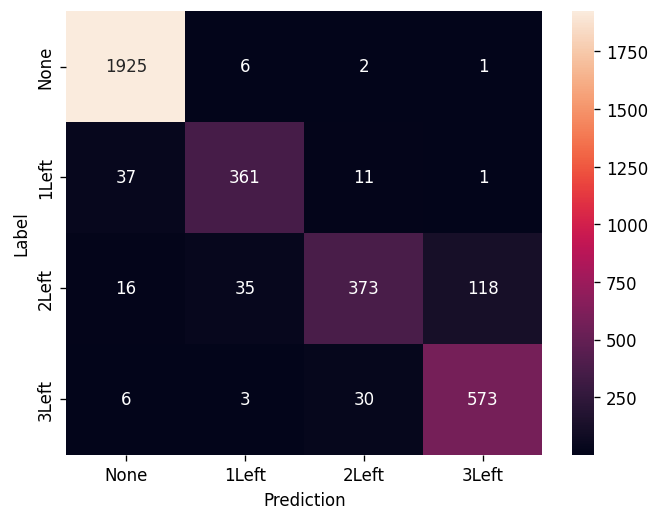

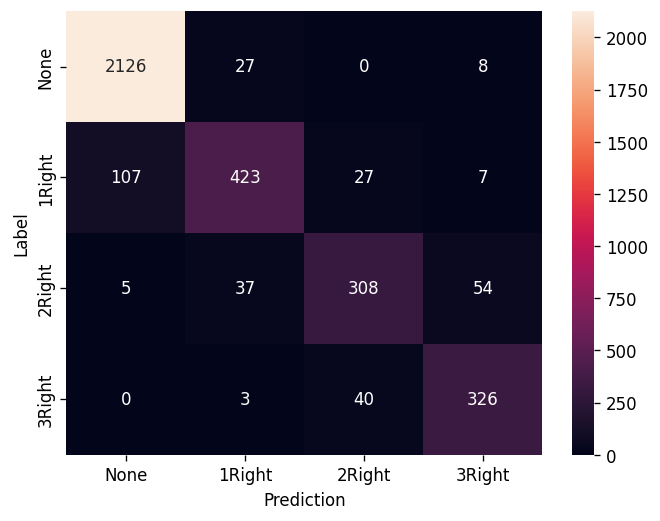

Left to Left
PRECISIONS: 	 None -  99.53  1 Car -  88.05  2 Car -  68.82  3 Car -  93.63
RECALLS: 	 None -  97.03  1 Car -  89.14  2 Car -  89.66  3 Car -  82.68
Left to Right
PRECISIONS: 	 None -  48.66  1 Car -  14.88  2 Car -  3.51  3 Car -  1.31
RECALLS: 	 None -  42.05  1 Car -  12.45  2 Car -  5.07  3 Car -  2.03
Right to Left
PRECISIONS: 	 None -  44.1  1 Car -  13.83  2 Car -  1.73  3 Car -  0.0
RECALLS: 	 None -  48.03  1 Car -  19.26  2 Car -  1.68  3 Car -  0.0
Right to Right
PRECISIONS: 	 None -  98.38  1 Car -  75.0  2 Car -  76.24  3 Car -  88.35
RECALLS: 	 None -  95.0  1 Car -  86.33  2 Car -  82.13  3 Car -  82.53


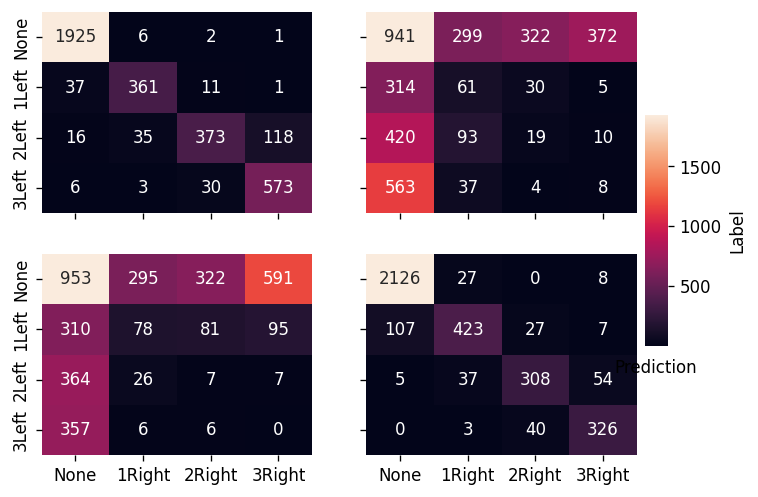

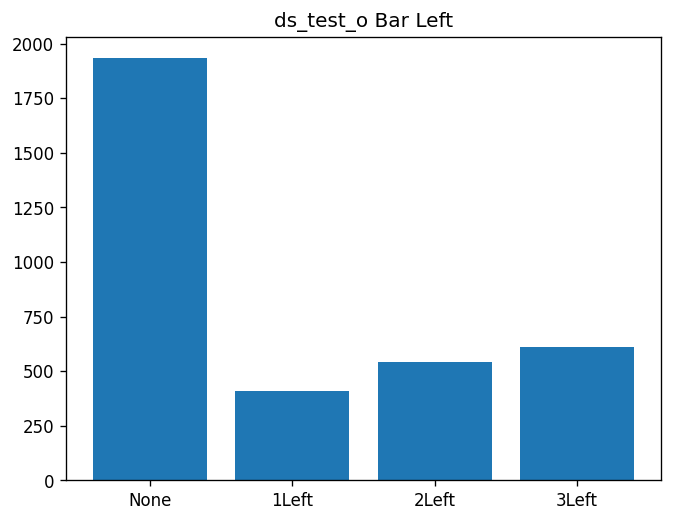

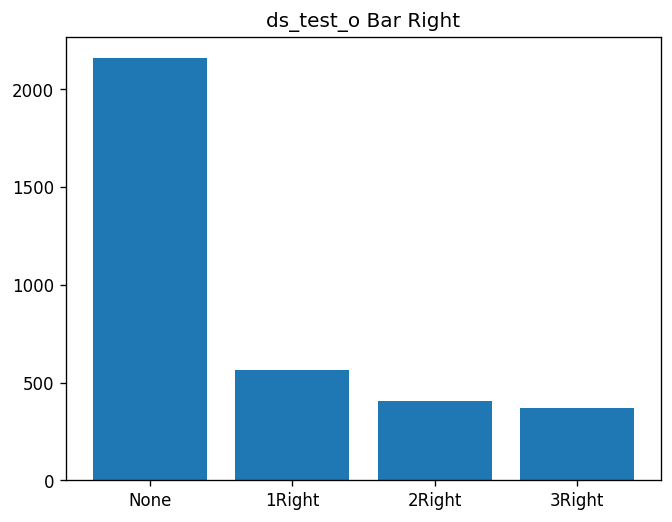

In [24]:
# print(p1.shape)
it1 = iter(ds_test_o)
it2 = iter(ds_test_names_o)
p1total = list()
p2total = list()
y1total = list()
y2total = list()

# for i in np.arange(13):
for i in np.arange(len(tfds.as_numpy(ds_test_names_o))):
    img, labels = next(it1)
    batch_names = next(it2)
    predictions_test = model.predict(img)
    p1, p2 = predictions_test
    y1, y2 = labels
    if i == 0:
        y1total = y1.numpy()
        p1total = p1
        y2total = y2.numpy()
        p2total = p2
    else:
        y1total = np.concatenate((y1total, y1.numpy()))
        y2total = np.concatenate((y2total, y2.numpy()))
        p1total = np.concatenate((p1total, p1))
        p2total = np.concatenate((p2total, p2))
#     PlotDataset(y1,y2)
# print((np.array(y1total)).shape)
# print((np.array(p1total)).shape)
ConfusionMatrix(p1total, p2total, y1total, y2total)
PlotDataset(y1total,y2total)
    #print(np.shape(predictions))
    #print(np.shape(labels))

4/4 [==============================] - 0s 27ms/step


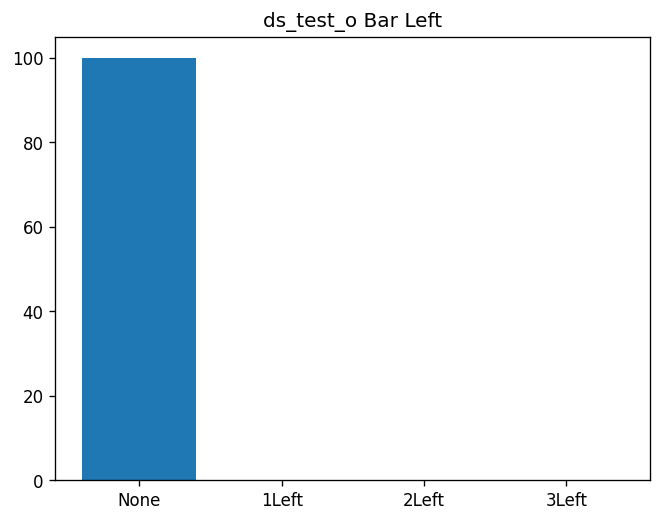

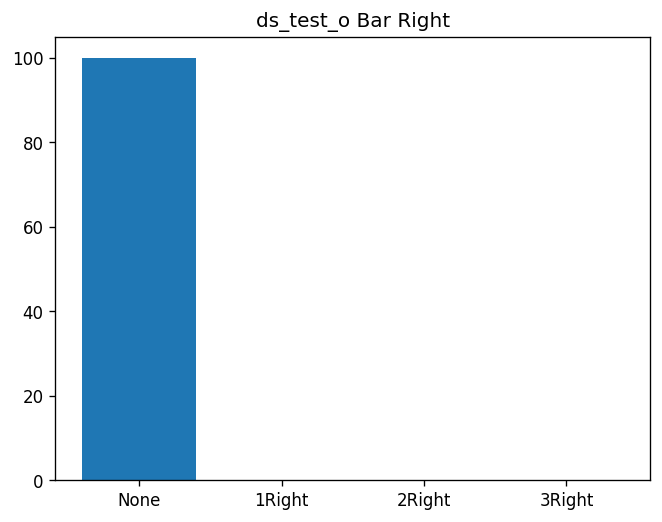

Labels:  [1. 0. 0. 0.] [1. 0. 0. 0.]
Predictions:  [1. 0. 0. 0.] [0. 1. 0. 0.]


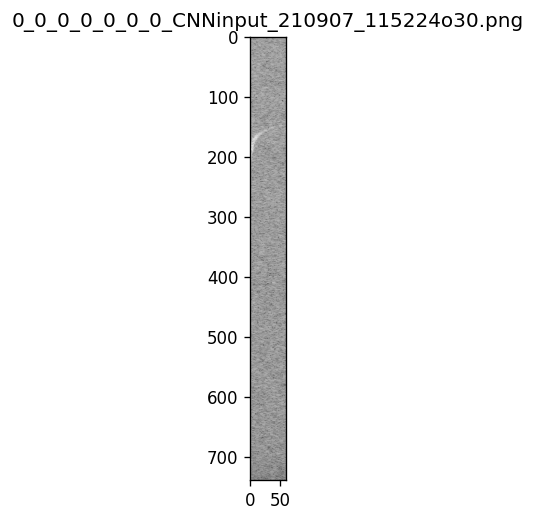

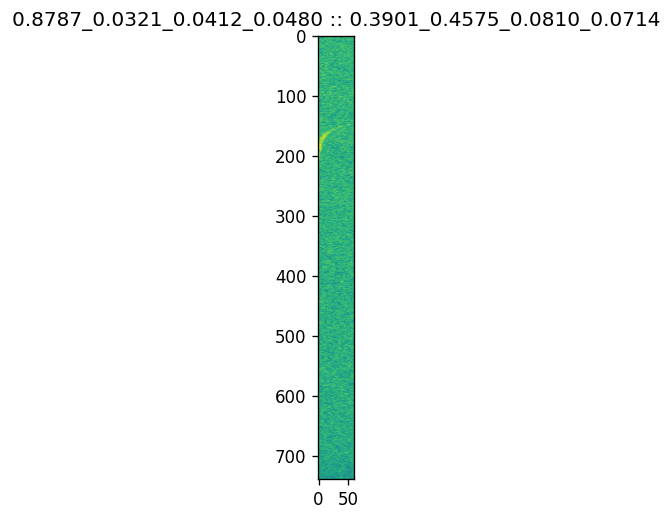

4/4 [==============================] - 0s 27ms/step


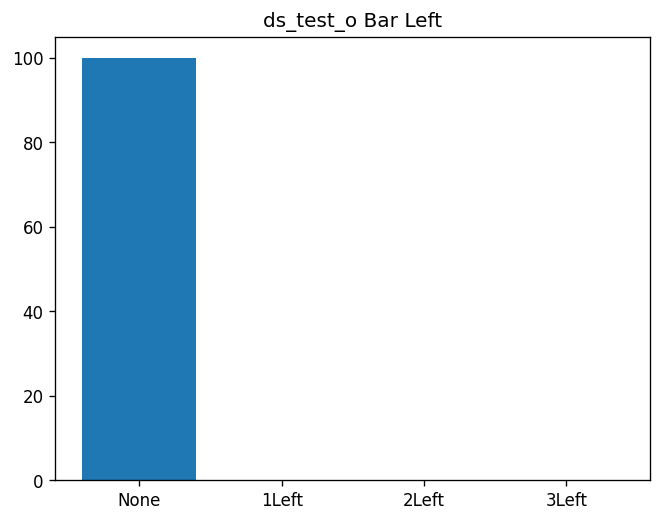

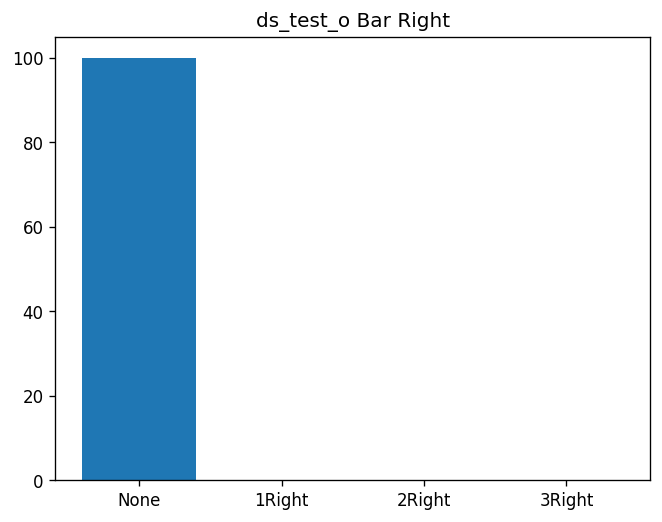

Labels:  [1. 0. 0. 0.] [1. 0. 0. 0.]
Predictions:  [1. 0. 0. 0.] [0. 1. 0. 0.]


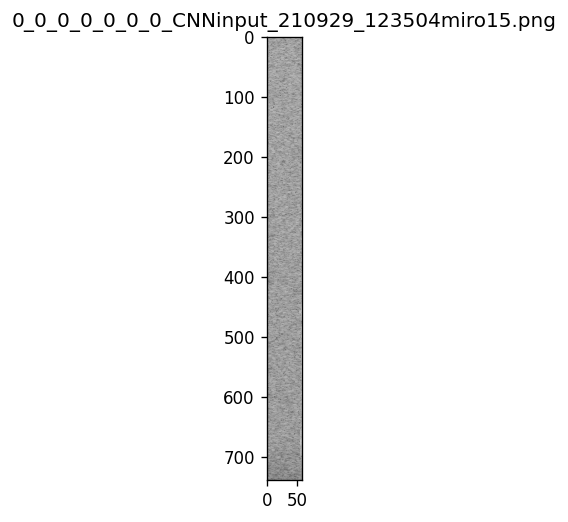

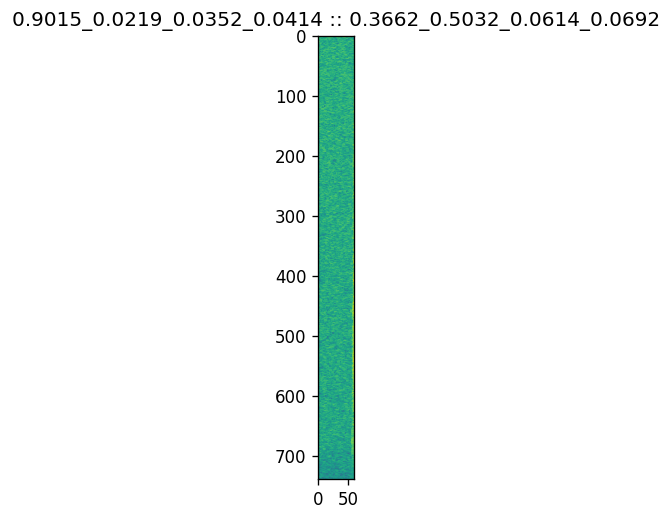

4/4 [==============================] - 0s 27ms/step


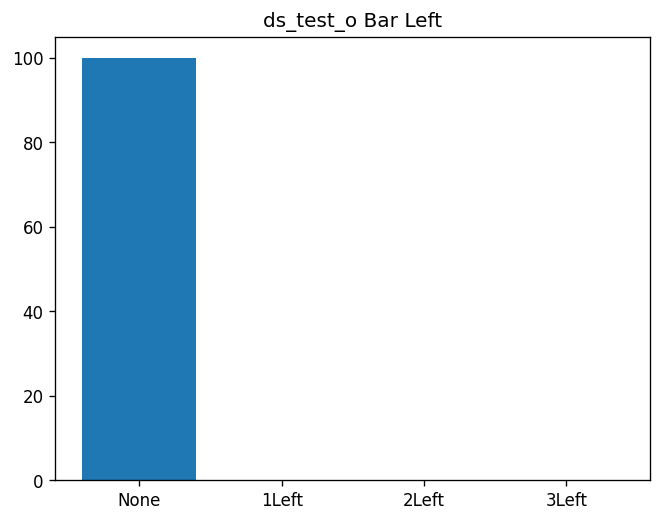

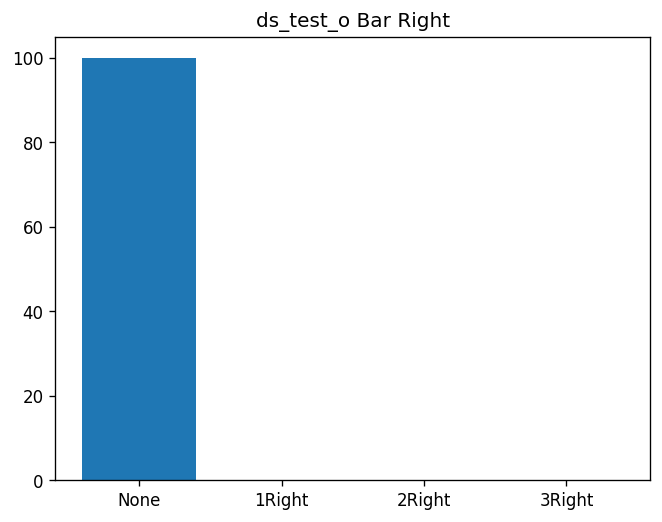

Labels:  [1. 0. 0. 0.] [1. 0. 0. 0.]
Predictions:  [1. 0. 0. 0.] [0. 1. 0. 0.]


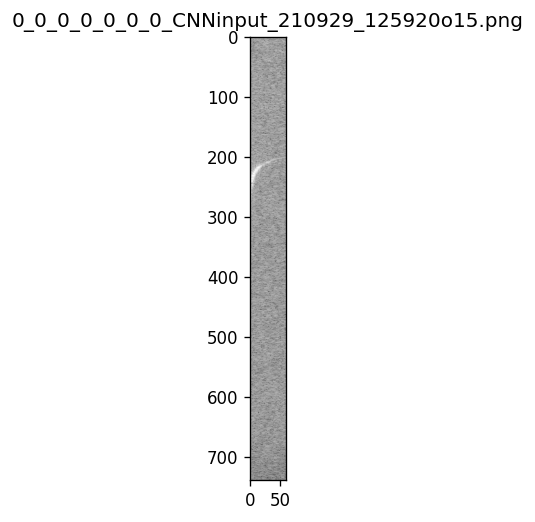

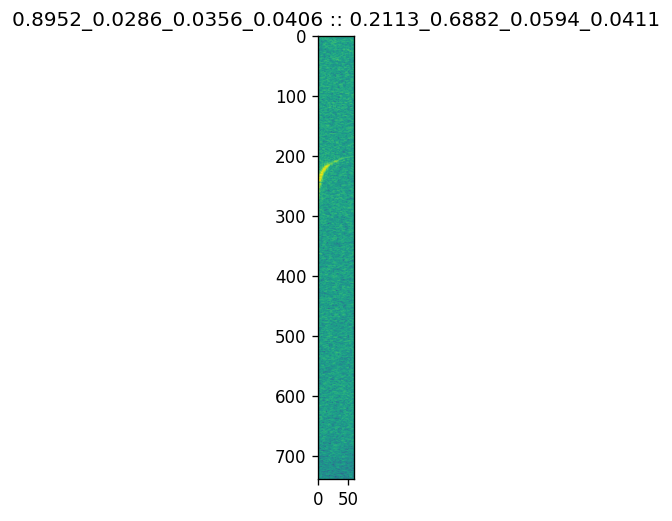

4/4 [==============================] - 0s 26ms/step


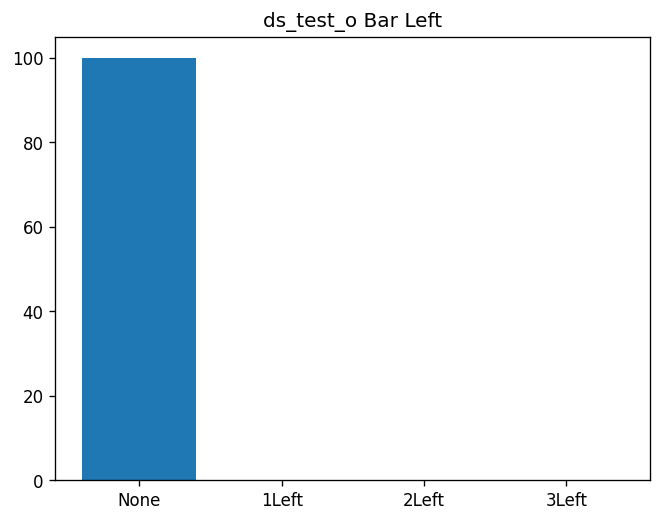

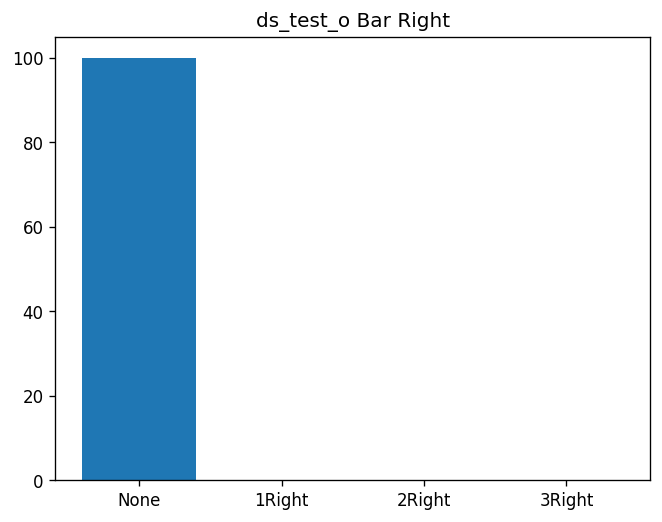

Labels:  [1. 0. 0. 0.] [1. 0. 0. 0.]
Predictions:  [1. 0. 0. 0.] [0. 1. 0. 0.]


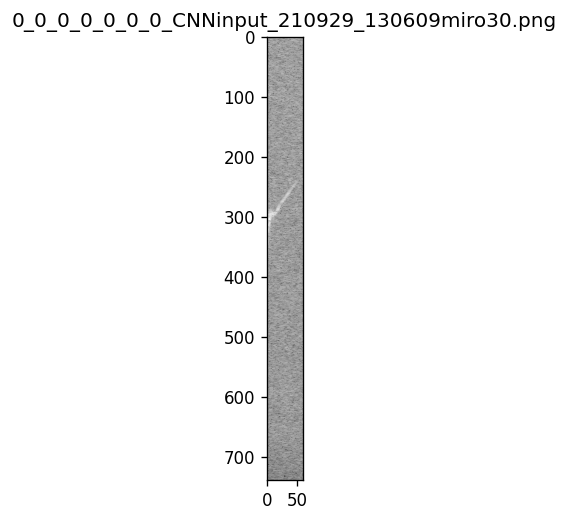

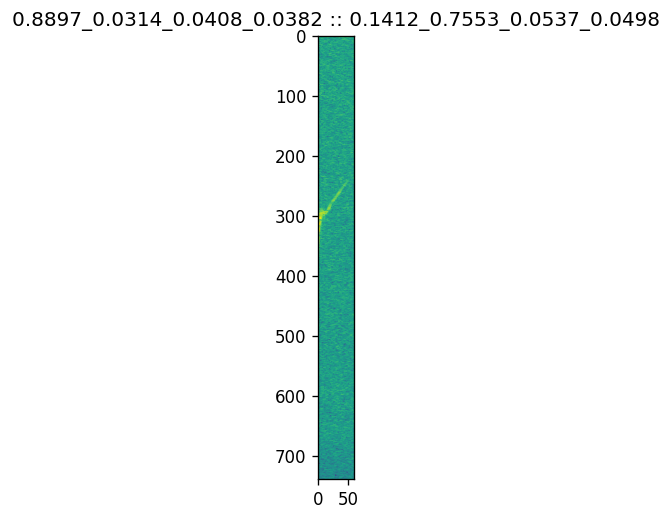

4/4 [==============================] - 0s 25ms/step


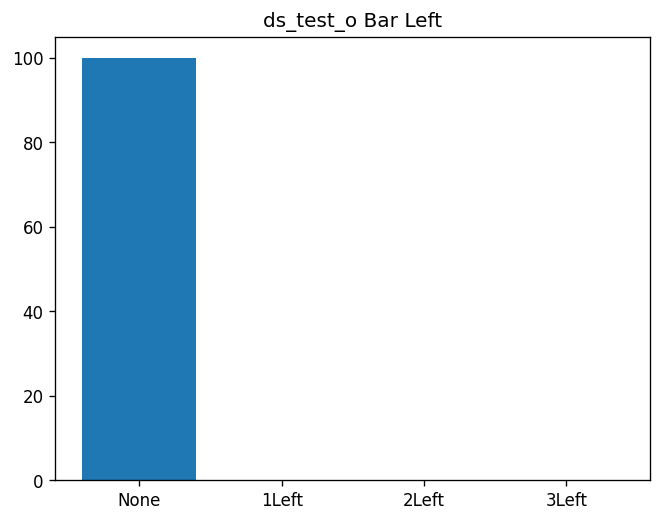

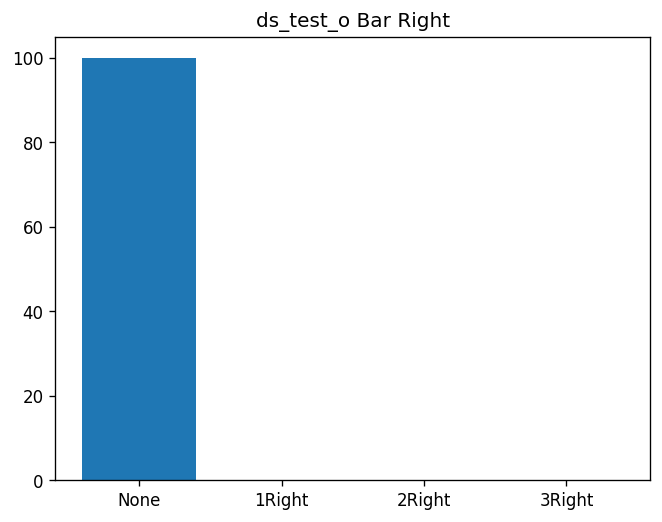

4/4 [==============================] - 0s 25ms/step


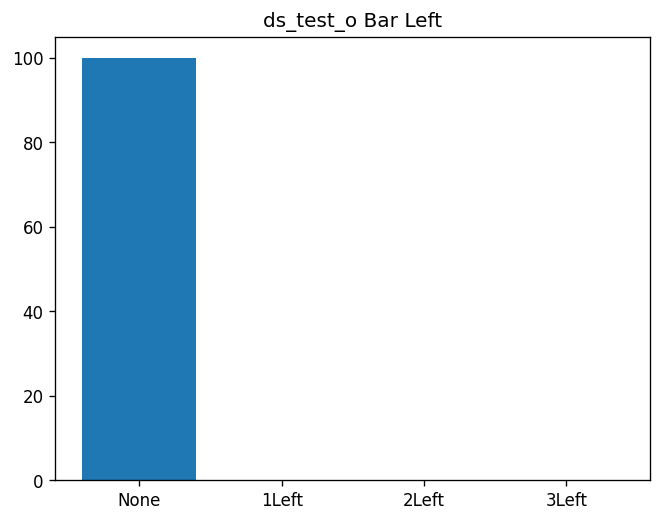

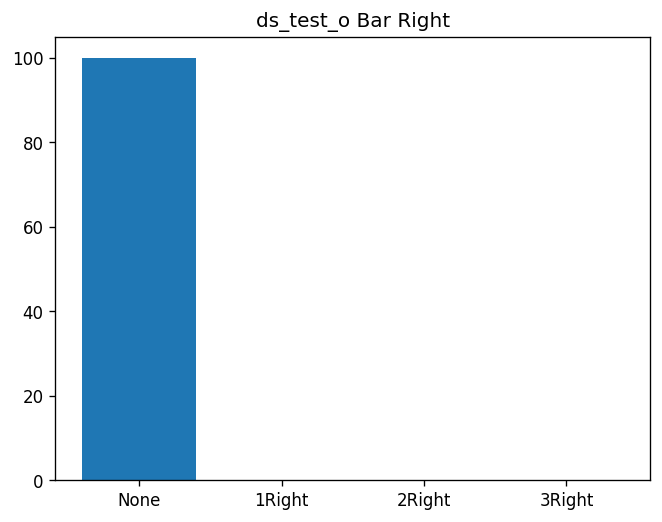

Labels:  [1. 0. 0. 0.] [1. 0. 0. 0.]
Predictions:  [1. 0. 0. 0.] [0. 1. 0. 0.]


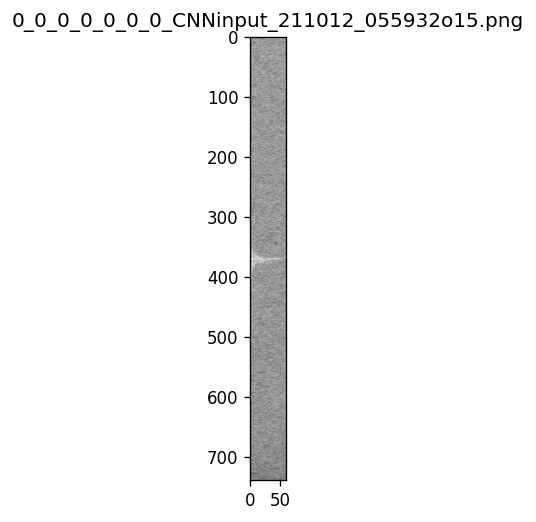

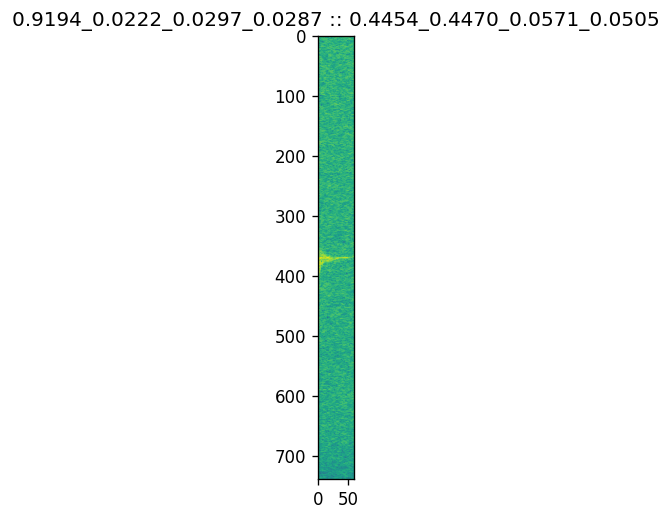

4/4 [==============================] - 0s 25ms/step


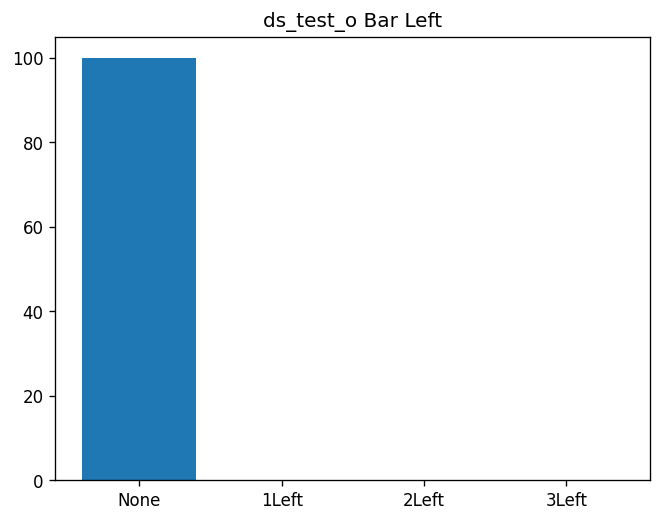

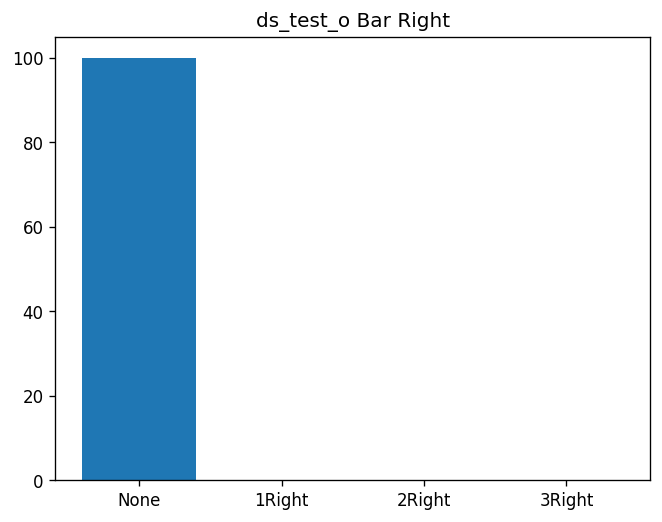

4/4 [==============================] - 0s 27ms/step


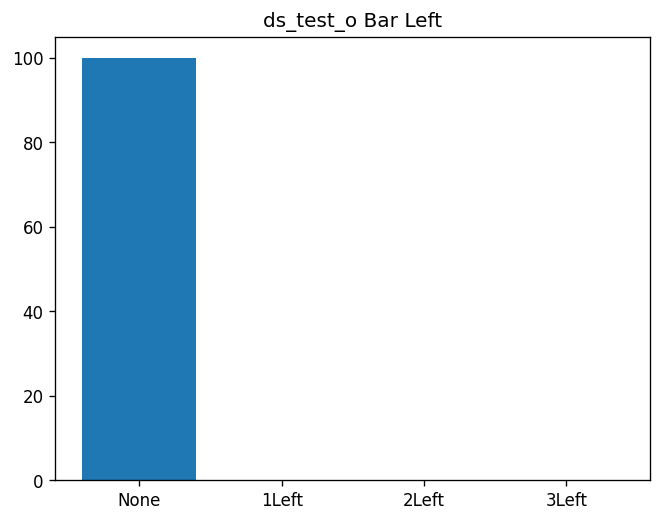

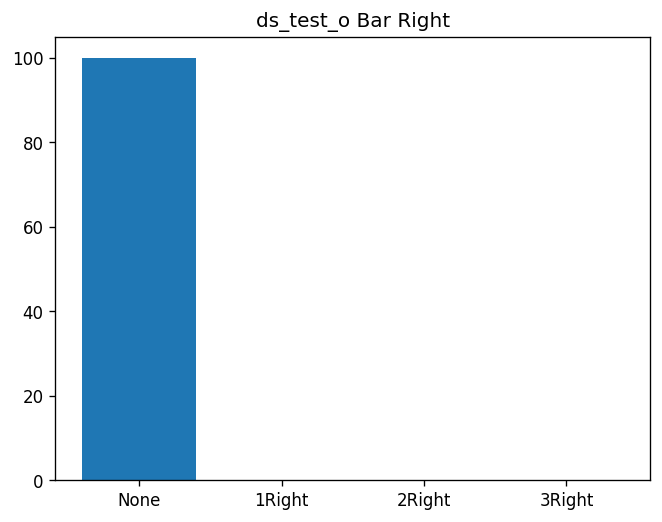

4/4 [==============================] - 0s 26ms/step


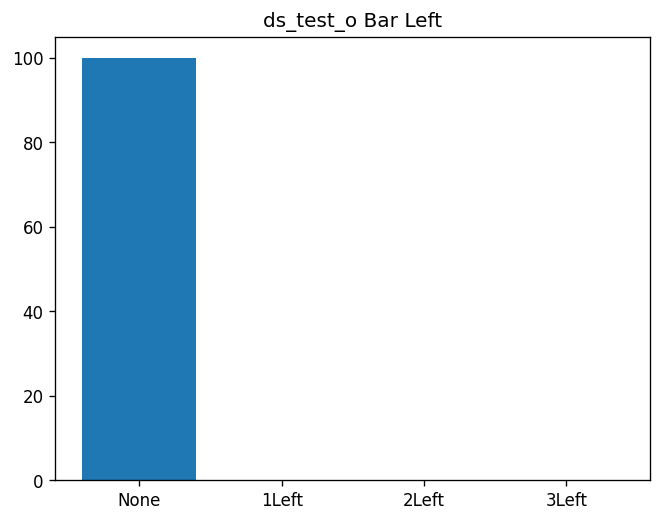

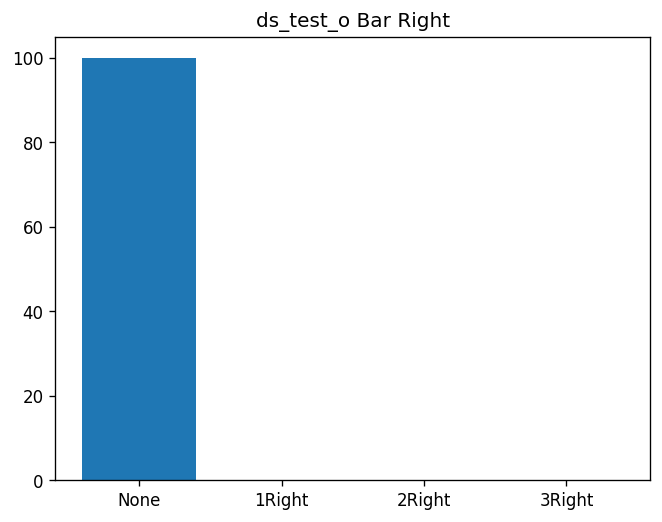

Labels:  [1. 0. 0. 0.] [1. 0. 0. 0.]
Predictions:  [1. 0. 0. 0.] [0. 1. 0. 0.]


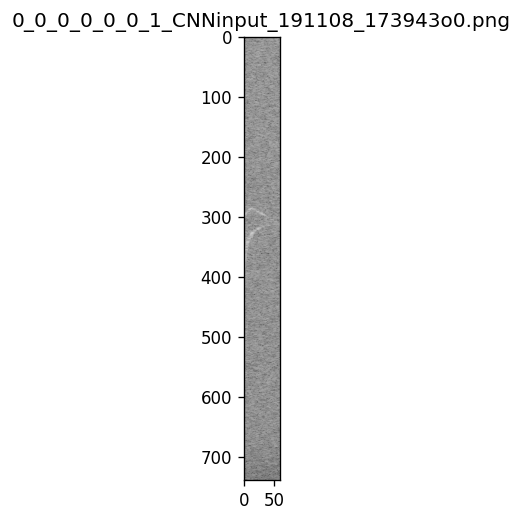

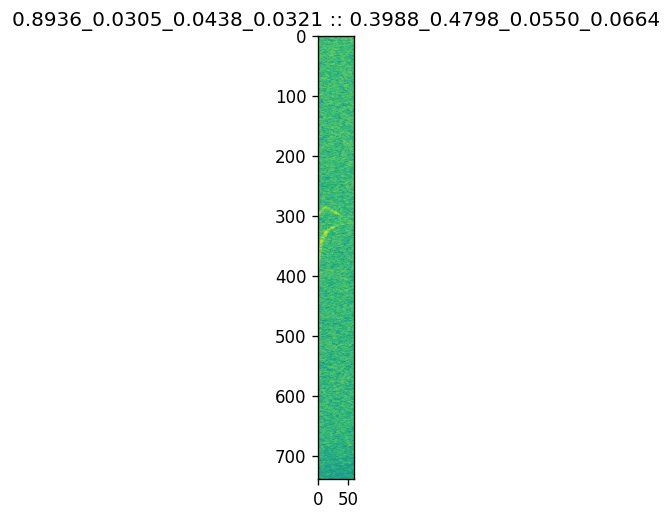

Labels:  [1. 0. 0. 0.] [1. 0. 0. 0.]
Predictions:  [0. 1. 0. 0.] [1. 0. 0. 0.]


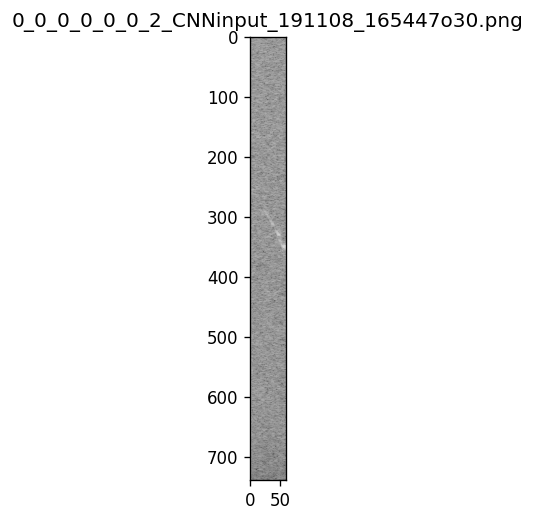

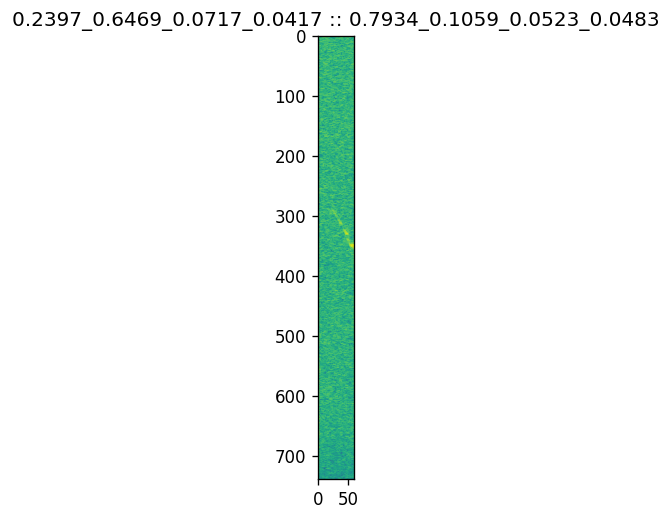

Labels:  [1. 0. 0. 0.] [1. 0. 0. 0.]
Predictions:  [0. 1. 0. 0.] [1. 0. 0. 0.]


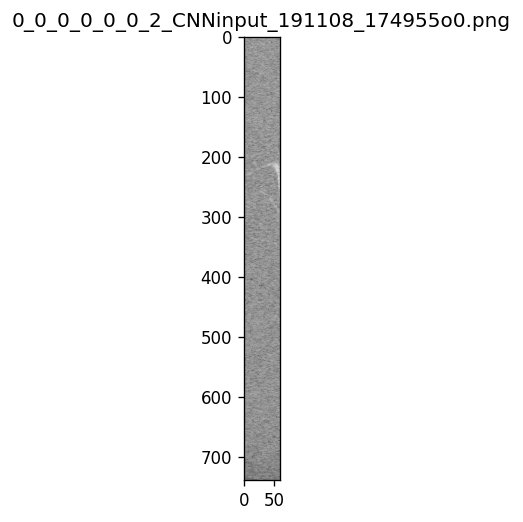

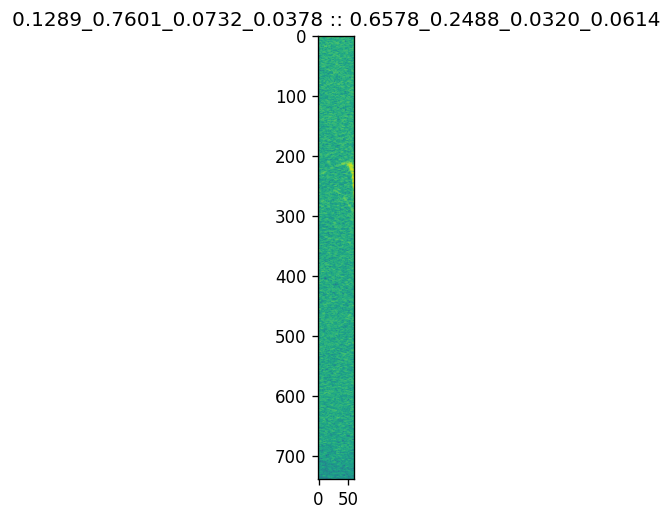

Labels:  [1. 0. 0. 0.] [1. 0. 0. 0.]
Predictions:  [1. 0. 0. 0.] [0. 1. 0. 0.]


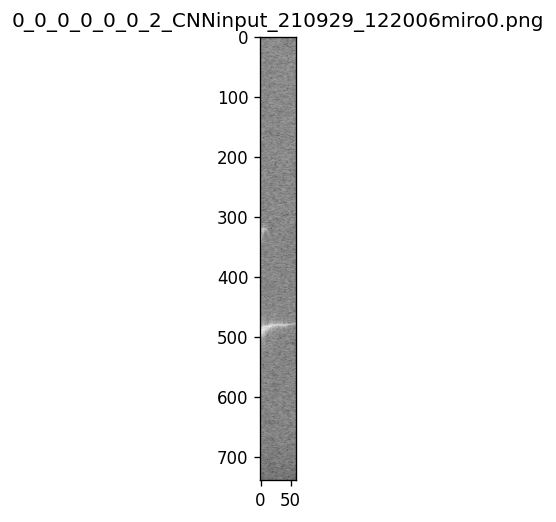

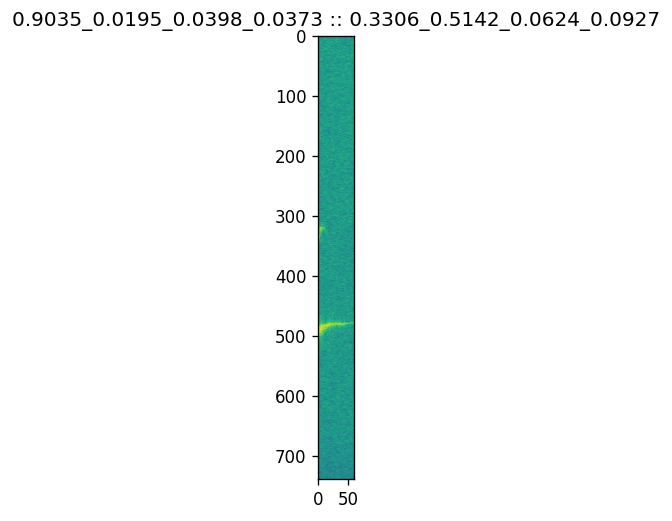

4/4 [==============================] - 0s 27ms/step


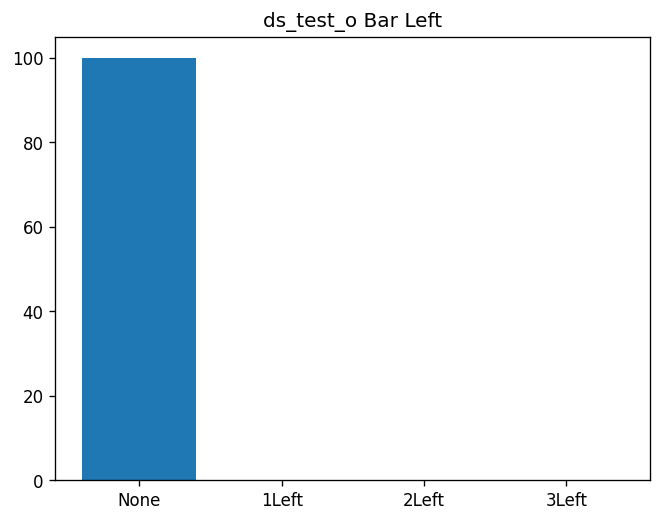

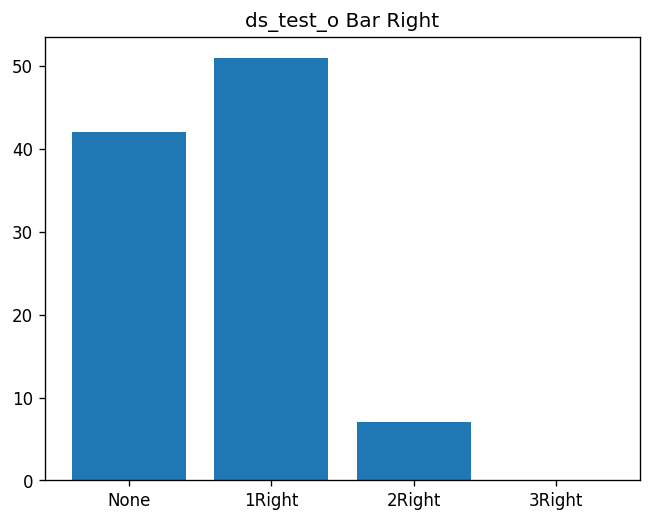

Labels:  [1. 0. 0. 0.] [0. 1. 0. 0.]
Predictions:  [1. 0. 0. 0.] [1. 0. 0. 0.]


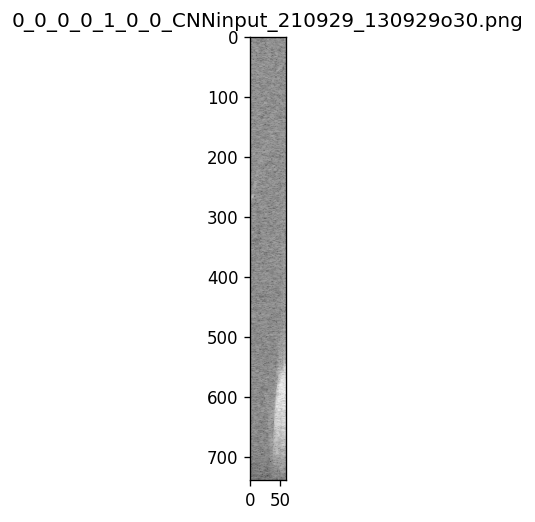

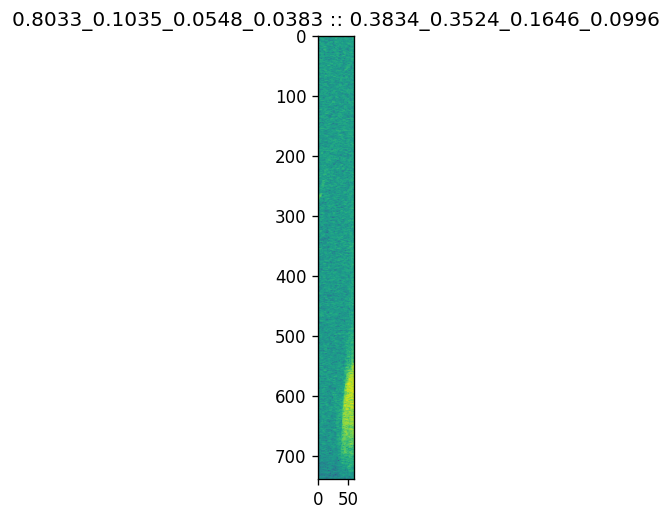

Labels:  [1. 0. 0. 0.] [0. 0. 1. 0.]
Predictions:  [1. 0. 0. 0.] [0. 1. 0. 0.]


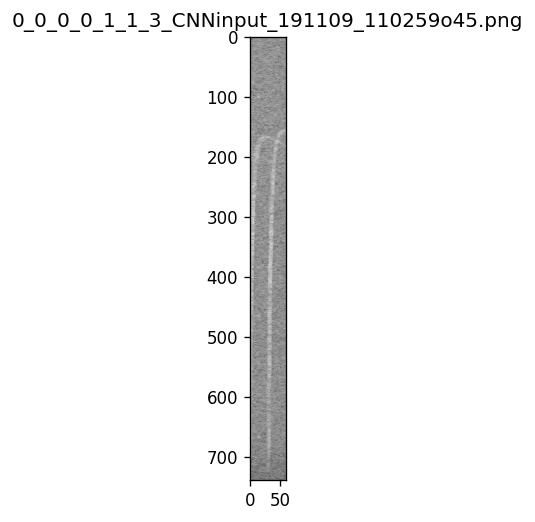

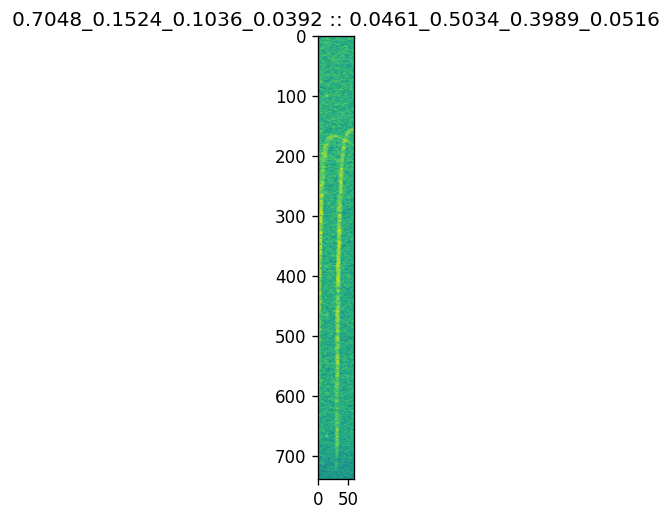

Labels:  [1. 0. 0. 0.] [0. 0. 1. 0.]
Predictions:  [1. 0. 0. 0.] [0. 1. 0. 0.]


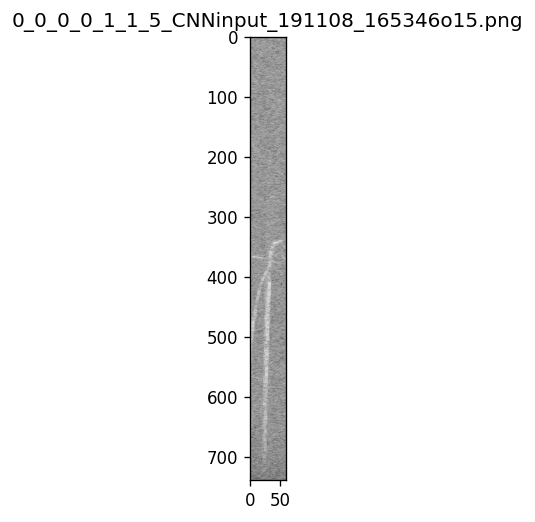

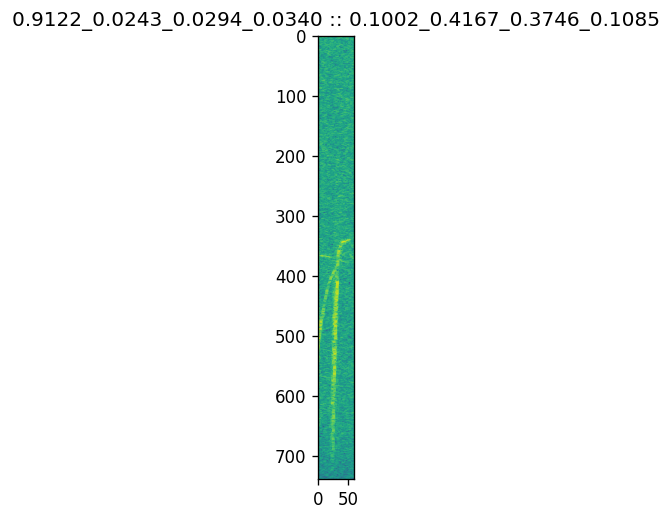

Labels:  [1. 0. 0. 0.] [0. 1. 0. 0.]
Predictions:  [1. 0. 0. 0.] [1. 0. 0. 0.]


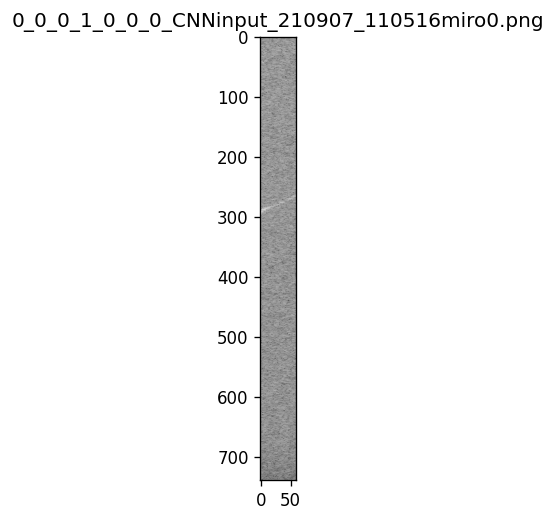

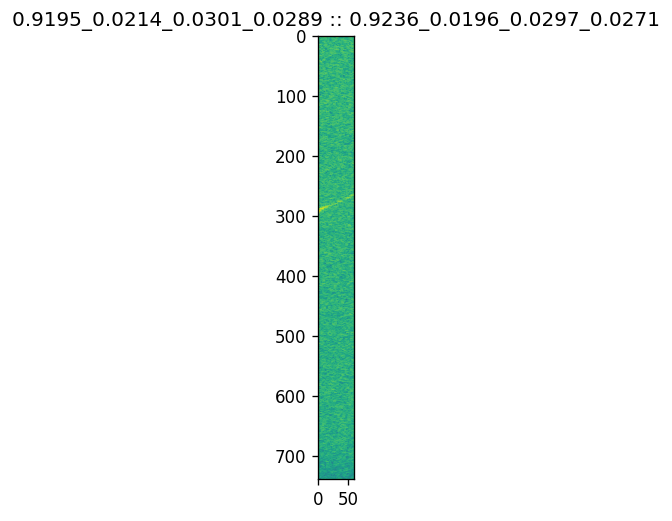

4/4 [==============================] - 0s 27ms/step


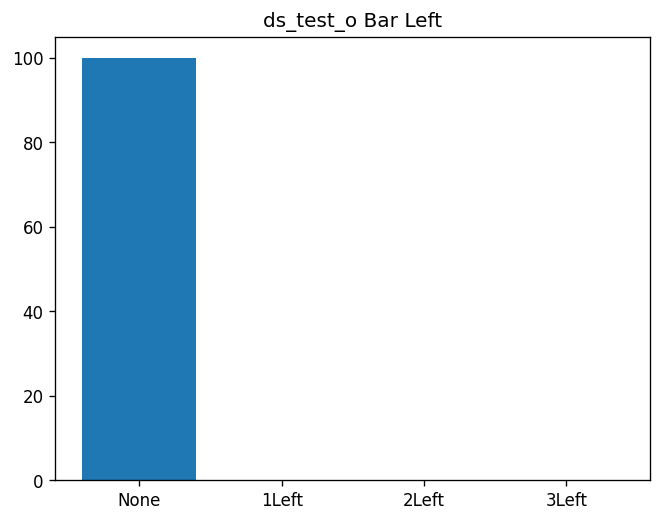

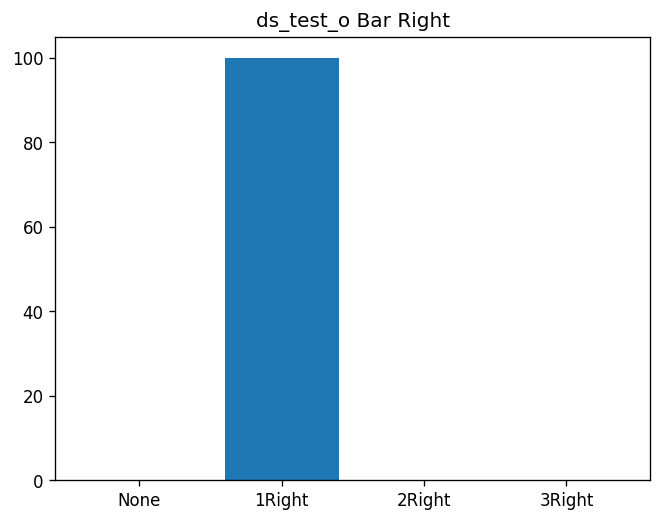

4/4 [==============================] - 0s 27ms/step


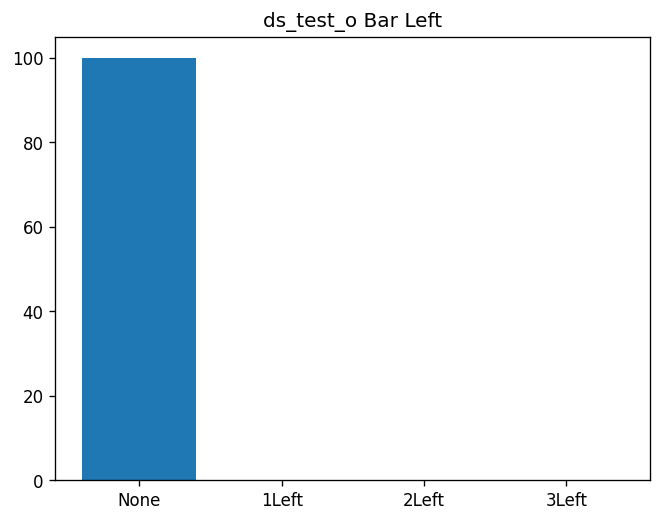

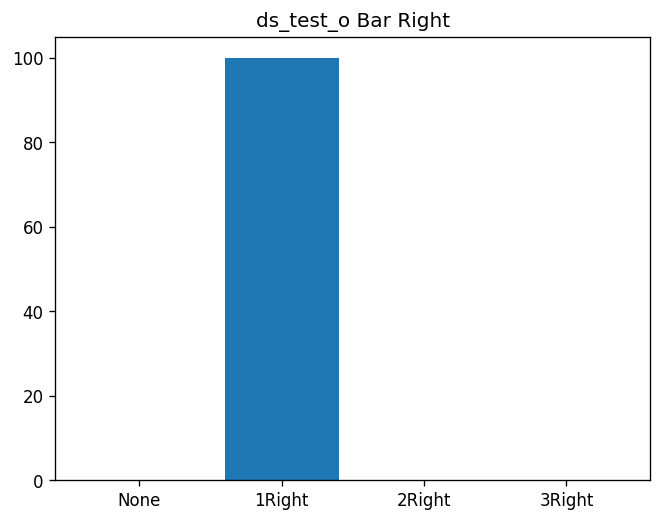

Labels:  [1. 0. 0. 0.] [0. 1. 0. 0.]
Predictions:  [1. 0. 0. 0.] [1. 0. 0. 0.]


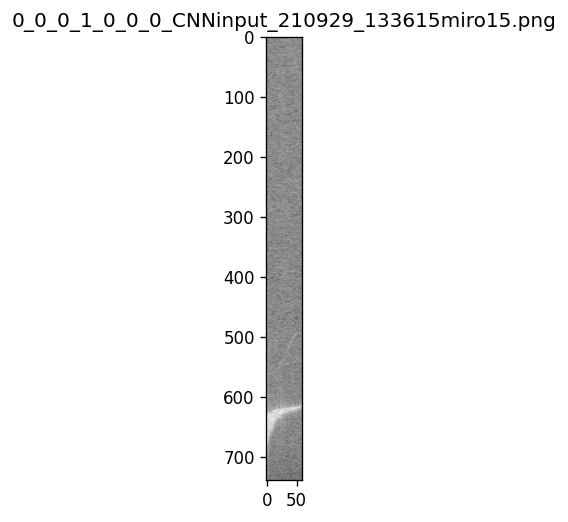

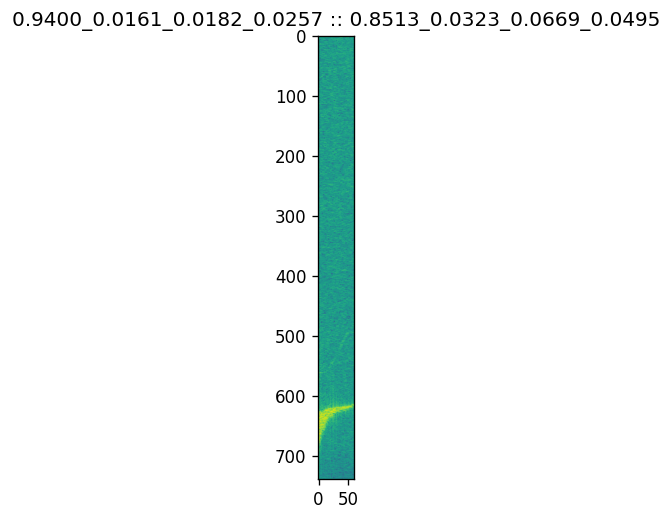

Labels:  [1. 0. 0. 0.] [0. 1. 0. 0.]
Predictions:  [1. 0. 0. 0.] [0. 0. 1. 0.]


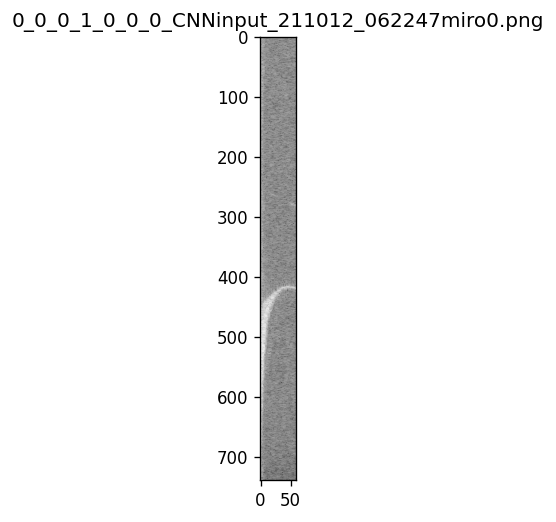

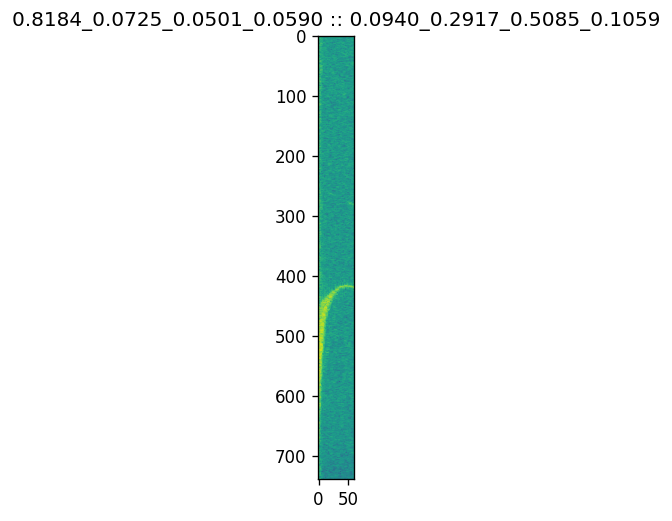

Labels:  [1. 0. 0. 0.] [0. 1. 0. 0.]
Predictions:  [1. 0. 0. 0.] [0. 0. 1. 0.]


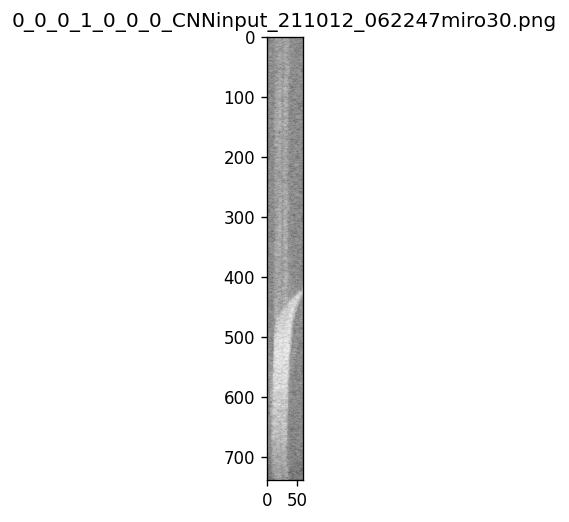

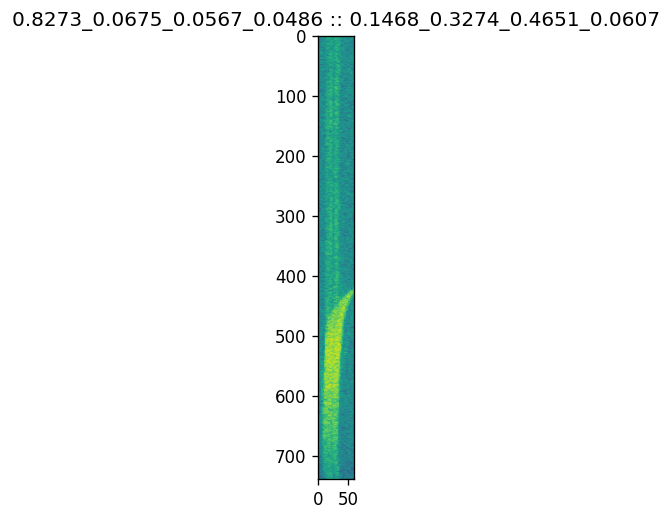

Labels:  [1. 0. 0. 0.] [0. 1. 0. 0.]
Predictions:  [1. 0. 0. 0.] [1. 0. 0. 0.]


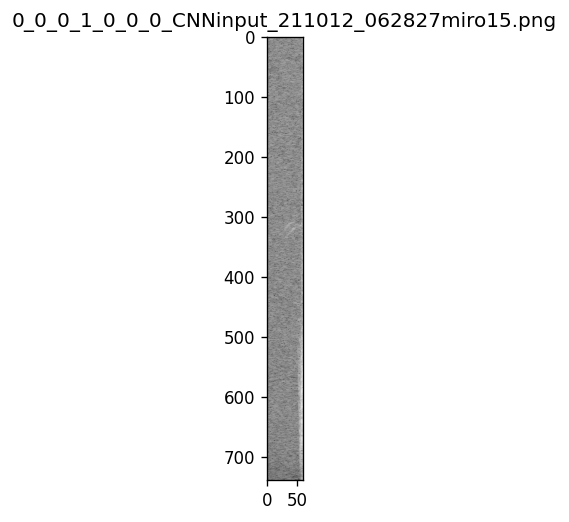

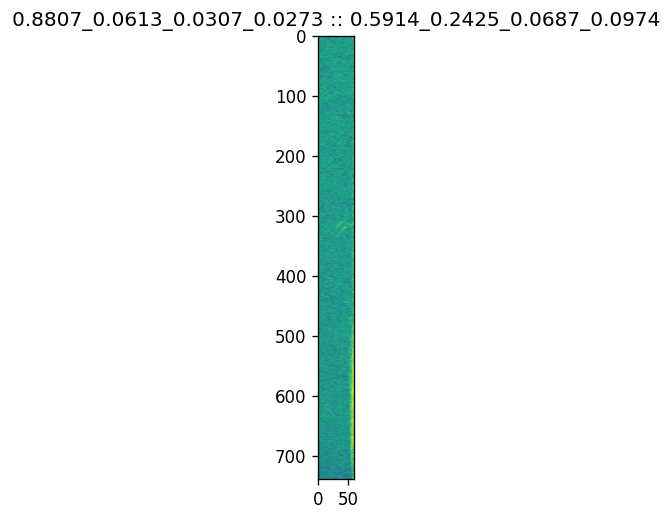

Labels:  [1. 0. 0. 0.] [0. 1. 0. 0.]
Predictions:  [0. 1. 0. 0.] [1. 0. 0. 0.]


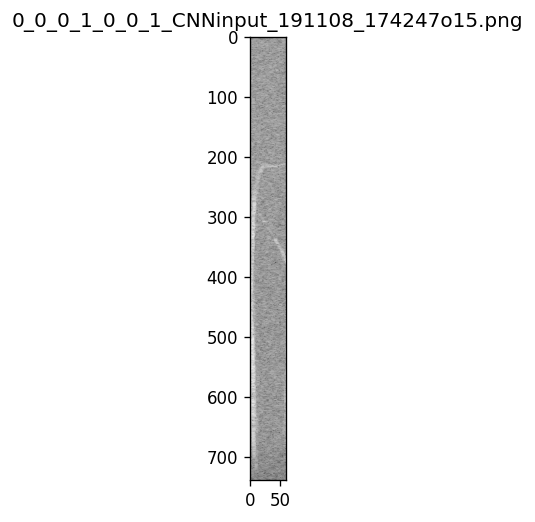

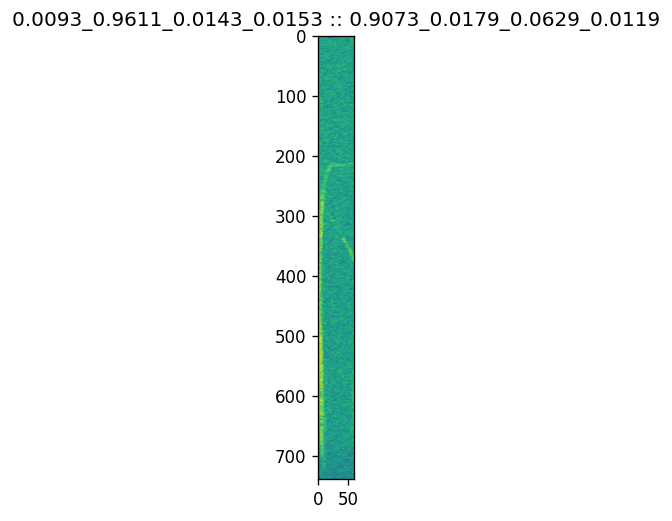

Labels:  [1. 0. 0. 0.] [0. 1. 0. 0.]
Predictions:  [1. 0. 0. 0.] [0. 0. 1. 0.]


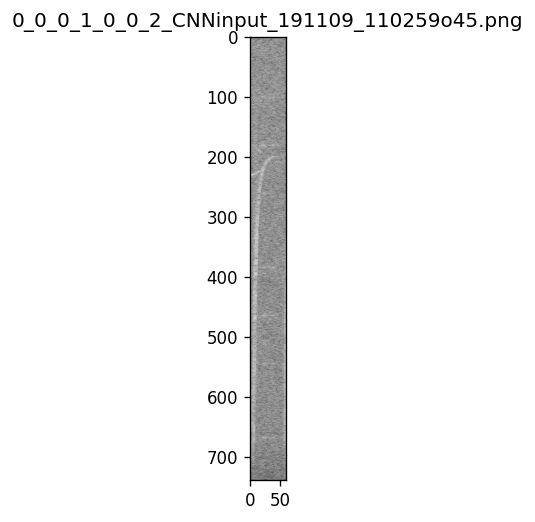

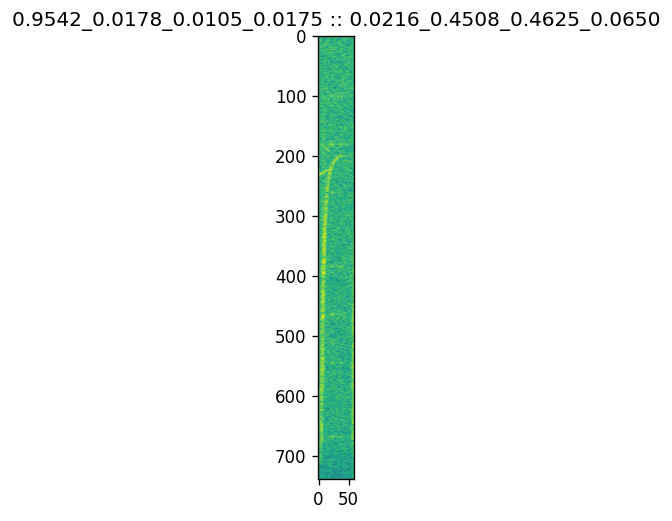

4/4 [==============================] - 0s 27ms/step


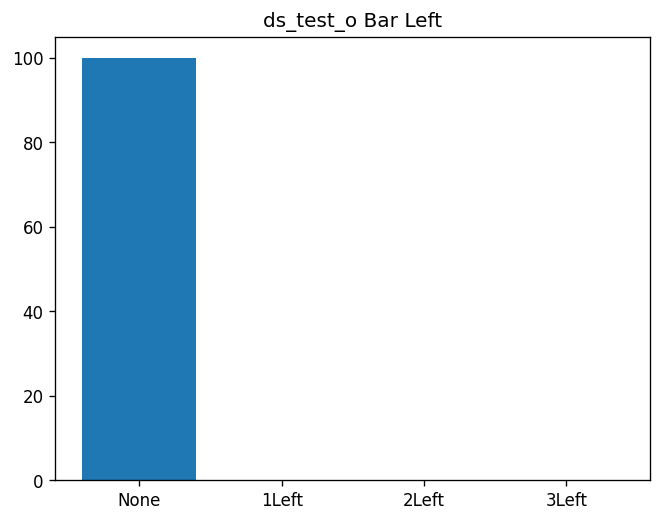

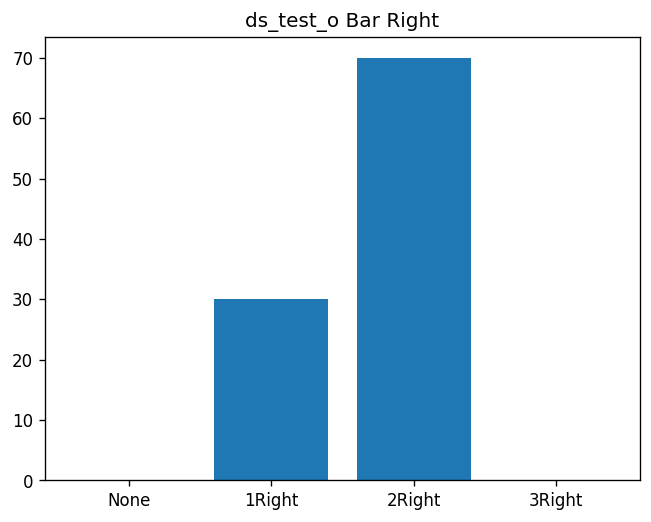

Labels:  [1. 0. 0. 0.] [0. 1. 0. 0.]
Predictions:  [1. 0. 0. 0.] [1. 0. 0. 0.]


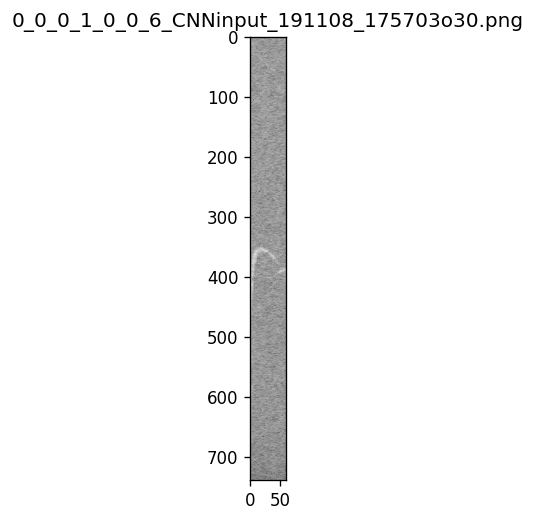

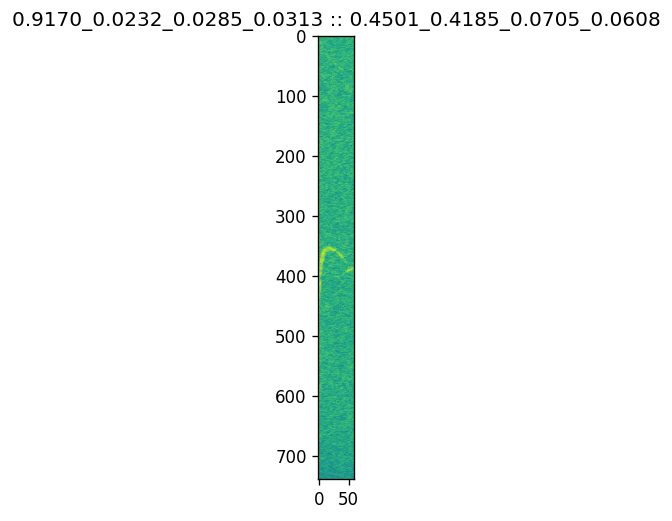

Labels:  [1. 0. 0. 0.] [0. 1. 0. 0.]
Predictions:  [1. 0. 0. 0.] [0. 0. 1. 0.]


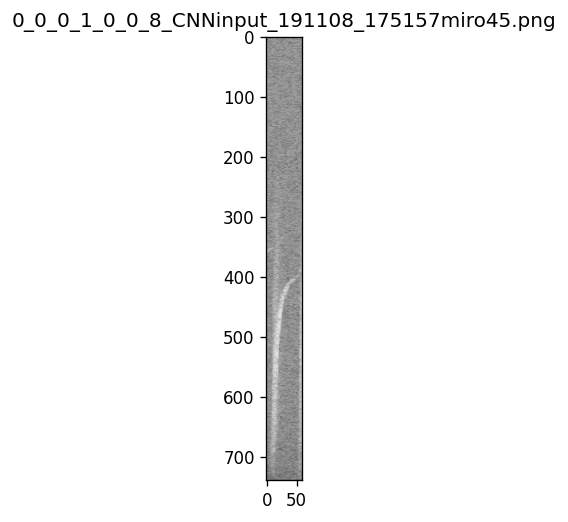

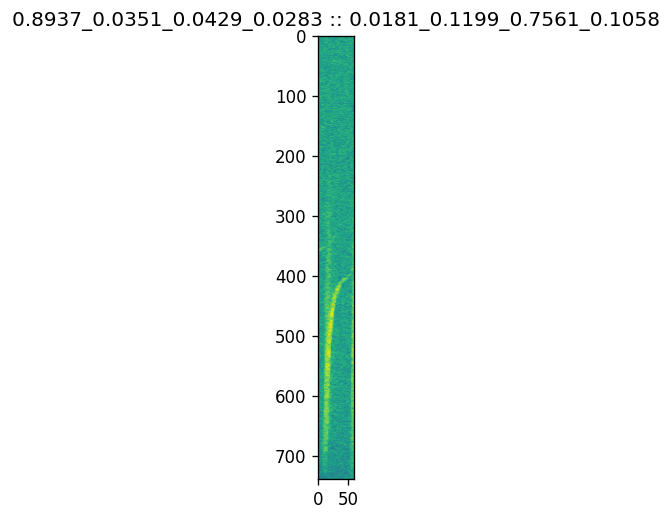

Labels:  [1. 0. 0. 0.] [0. 0. 1. 0.]
Predictions:  [1. 0. 0. 0.] [0. 1. 0. 0.]


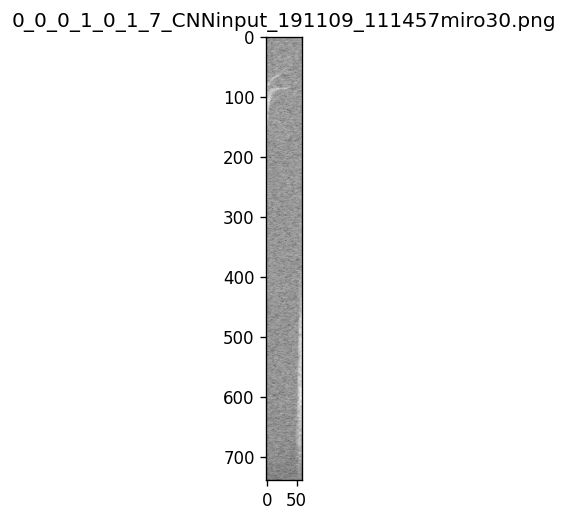

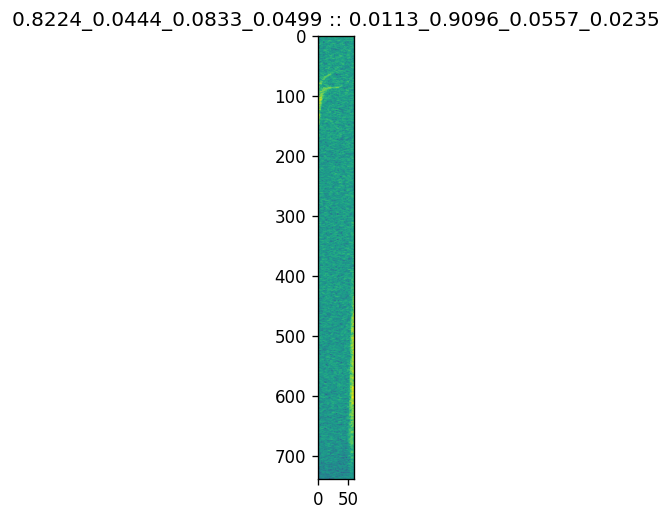

Labels:  [1. 0. 0. 0.] [0. 0. 1. 0.]
Predictions:  [1. 0. 0. 0.] [0. 0. 0. 1.]


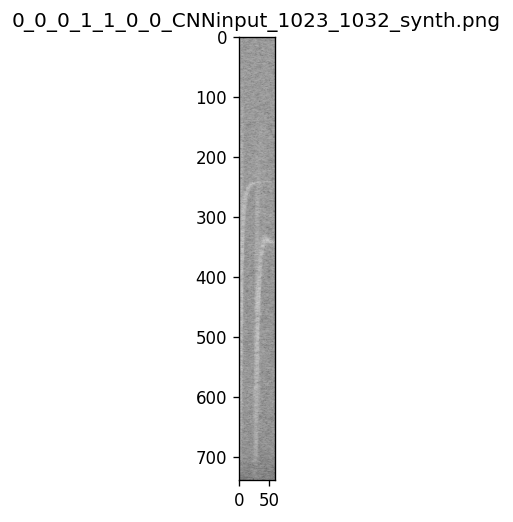

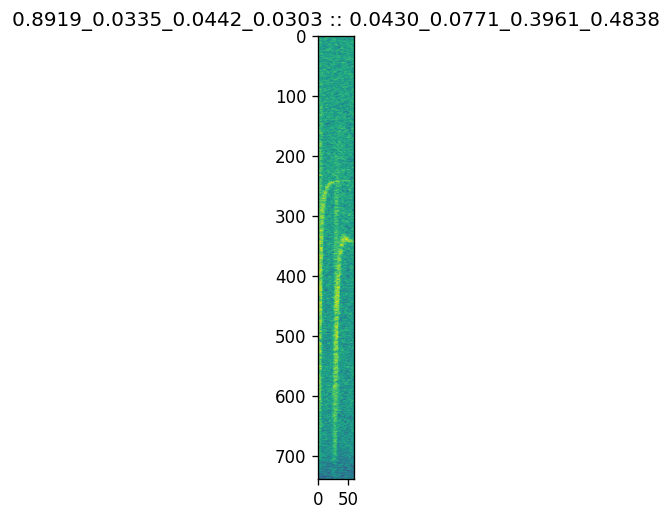

Labels:  [1. 0. 0. 0.] [0. 0. 1. 0.]
Predictions:  [1. 0. 0. 0.] [0. 0. 0. 1.]


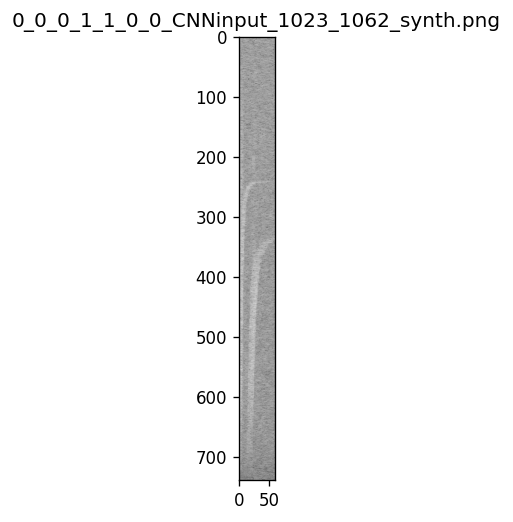

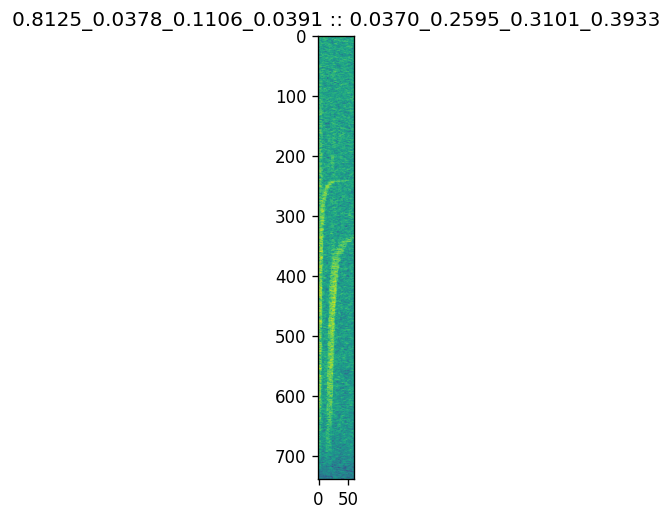

Labels:  [1. 0. 0. 0.] [0. 0. 1. 0.]
Predictions:  [1. 0. 0. 0.] [0. 0. 0. 1.]


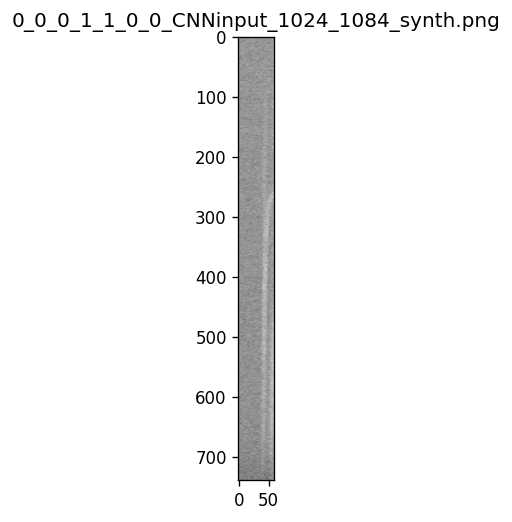

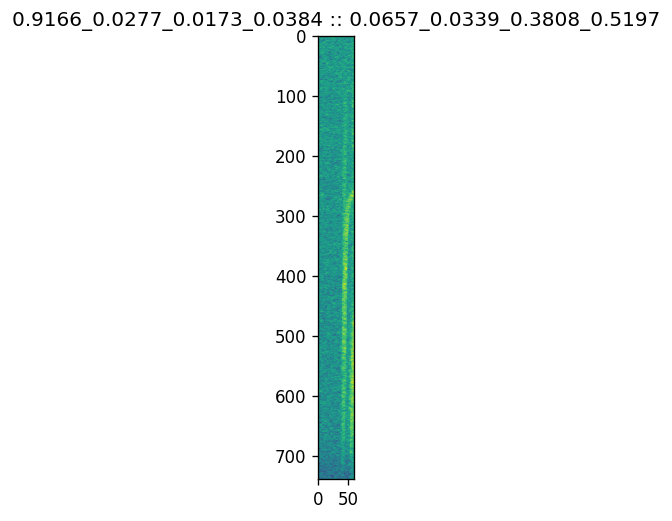

Labels:  [1. 0. 0. 0.] [0. 0. 1. 0.]
Predictions:  [1. 0. 0. 0.] [0. 0. 0. 1.]


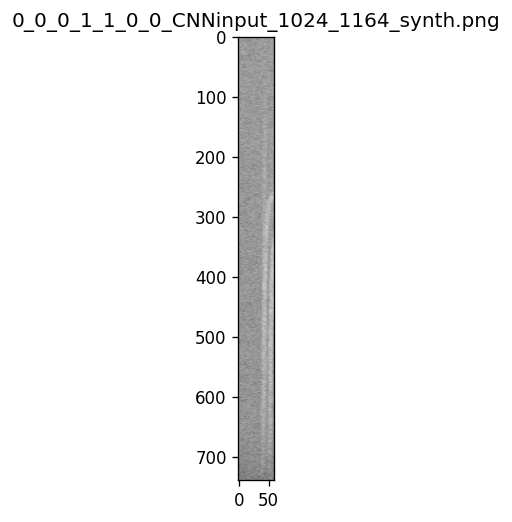

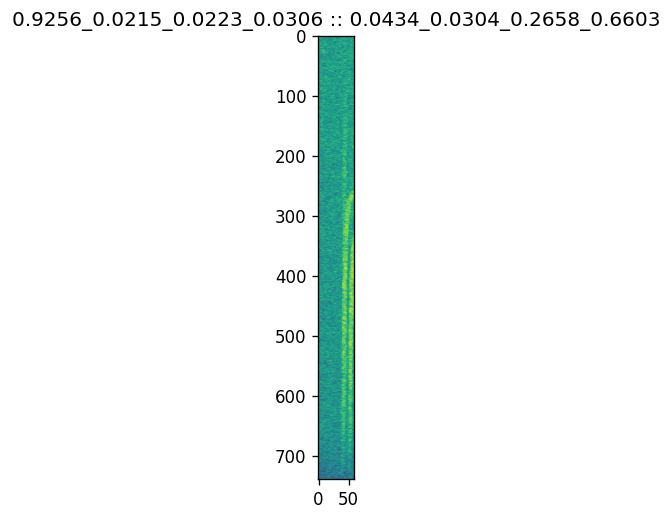

Labels:  [1. 0. 0. 0.] [0. 0. 1. 0.]
Predictions:  [1. 0. 0. 0.] [0. 0. 0. 1.]


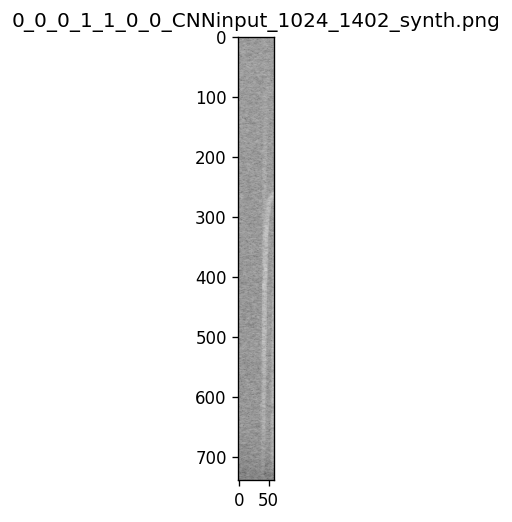

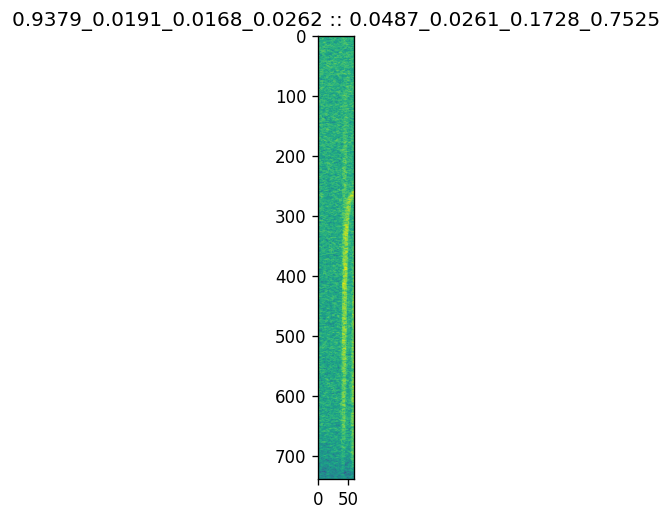

Labels:  [1. 0. 0. 0.] [0. 0. 1. 0.]
Predictions:  [1. 0. 0. 0.] [0. 0. 0. 1.]


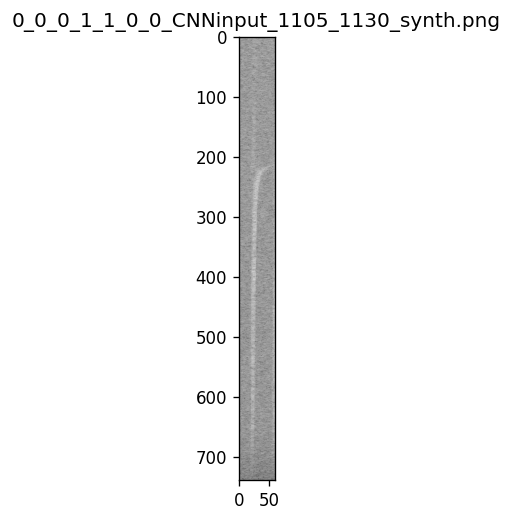

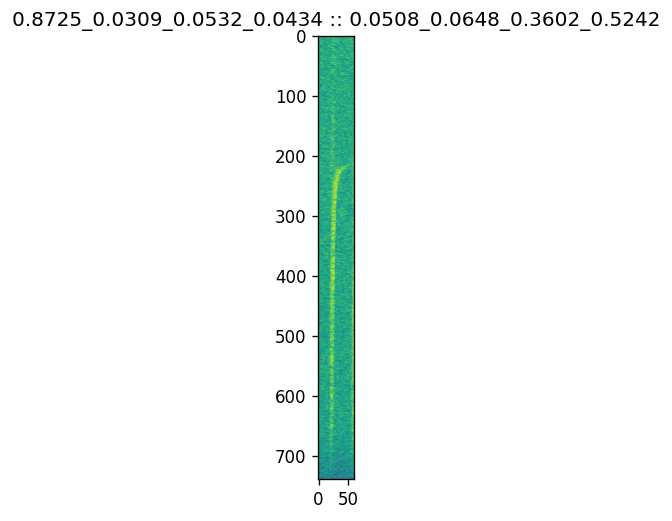

Labels:  [1. 0. 0. 0.] [0. 0. 1. 0.]
Predictions:  [1. 0. 0. 0.] [0. 0. 0. 1.]


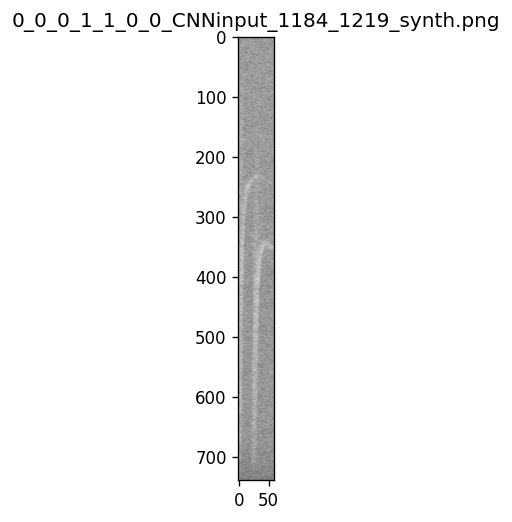

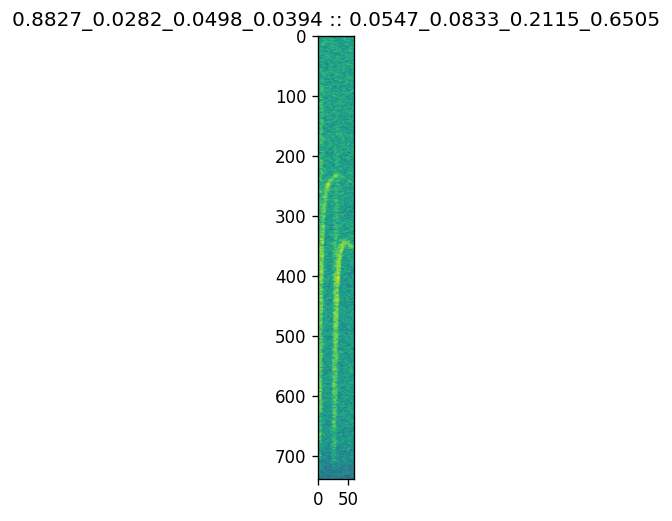

Labels:  [1. 0. 0. 0.] [0. 0. 1. 0.]
Predictions:  [1. 0. 0. 0.] [0. 0. 0. 1.]


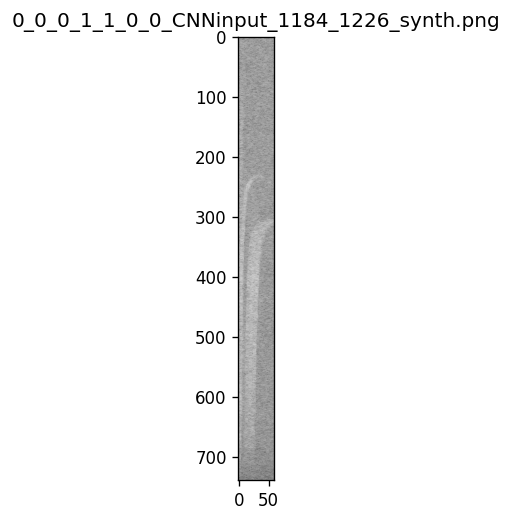

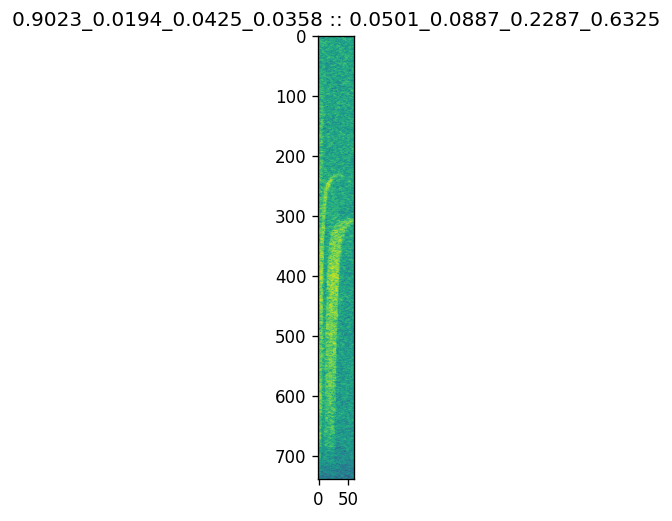

Labels:  [1. 0. 0. 0.] [0. 0. 1. 0.]
Predictions:  [1. 0. 0. 0.] [0. 0. 0. 1.]


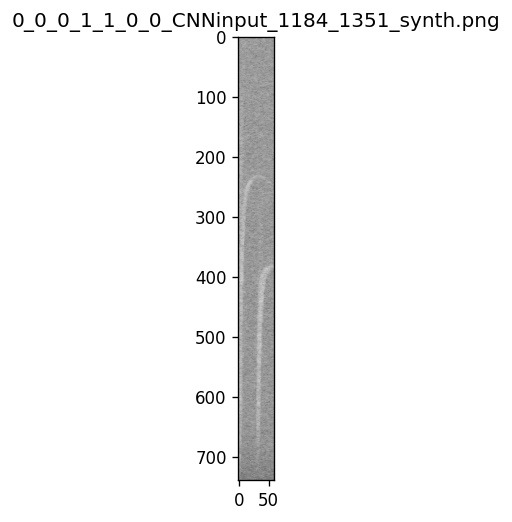

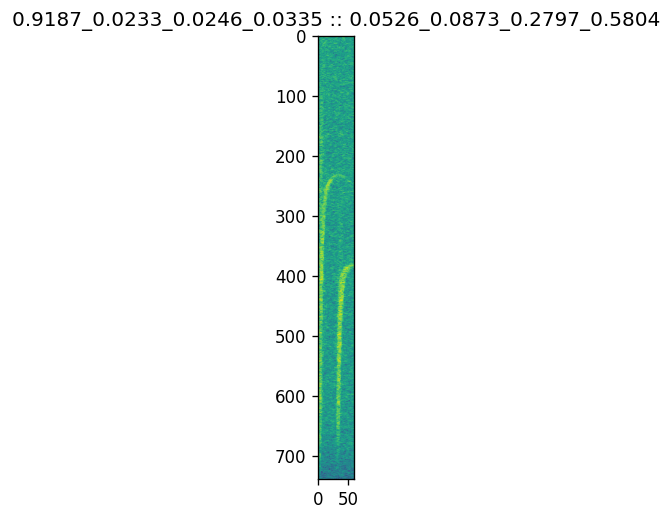

Labels:  [1. 0. 0. 0.] [0. 0. 1. 0.]
Predictions:  [1. 0. 0. 0.] [0. 0. 0. 1.]


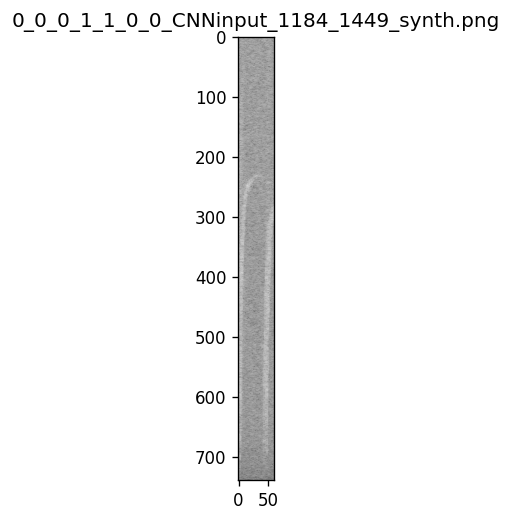

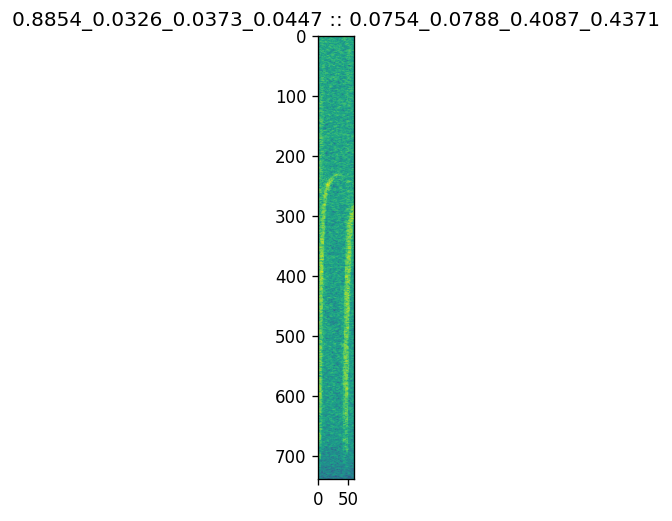

Labels:  [1. 0. 0. 0.] [0. 0. 1. 0.]
Predictions:  [1. 0. 0. 0.] [0. 0. 0. 1.]


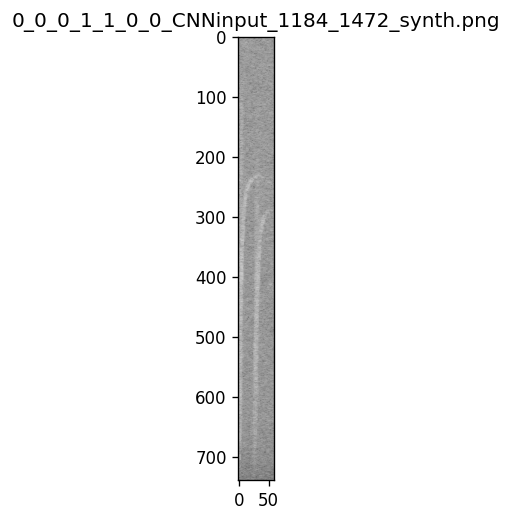

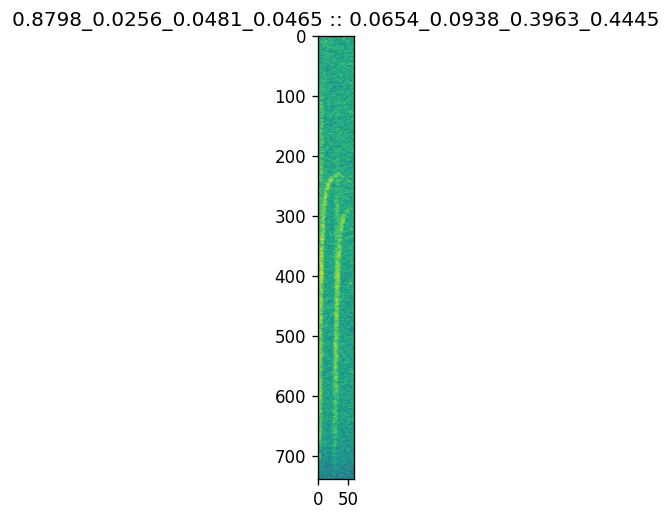

In [25]:
it1 = iter(ds_test_o)
it2 = iter(ds_test_names_o)

for i in np.arange(13):
    img, labels = next(it1)
    batch_names = next(it2)
    y1, y2 = labels
    b = y1.numpy().shape[0]
    predictions_test = model.predict(img)
    PlotDataset(y1,y2)
    for i in np.arange(b):
        p1, p2 = predictions_test
        current_name = batch_names[i].numpy().decode("UTF-8")
        current_img = cv2.imread(current_name, cv2.IMREAD_COLOR)
        current_img = cv2.cvtColor(current_img, cv2.COLOR_BGR2RGB)

        z1 = np.zeros((4))
        predictions2_max_i = np.argmax(p1[i])
        z1[predictions2_max_i] = 1
        z2 = np.zeros((4))
        predictions2_max_i = np.argmax(p2[i])
        z2[predictions2_max_i] = 1
        
        if np.any(np.not_equal(y1[i], z1)) or np.any(np.not_equal(y2[i], z2)):
            print("Labels: ", np.array(y1[i]), np.array(y2[i]))
            print("Predictions: ", z1, z2)
            plotImage(current_img, title=os.path.basename(current_name))
            plotImage(img[i].numpy(), title=f"{predictionsToText(p1[i], sep='_')} :: {predictionsToText(p2[i], sep='_')}")
#         plotImage(img[i].numpy(), title=f"{p1[i]}_{p2[i]}_{p3[i]}_{p4[i]}_{p5[i]}_{p6[i]}")
#         plotImage(img[i].numpy(), title=f"{y1[i].numpy().astype(np.uint8)}_{y2[i].numpy().astype(np.uint8)}_{y3[i].numpy().astype(np.uint8)}_{y4[i].numpy().astype(np.uint8)}_{y5[i].numpy().astype(np.uint8)}_{y6[i].numpy().astype(np.uint8)}")